# SPAN Benchmarks H3K27ac vs DHS

In [15]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import pyBigWig
import tempfile
from itertools import product

In [302]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

# Load hg38 peaks


In [303]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K27ac']
GSE26320_REPS = ['rep1', 'rep2']

! mkdir -p {GSE26320_PATH_HG38}/pics

In [304]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [305]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 17


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 17


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 17


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 17


file modification  cell  \
2   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac  NHEK   
4   /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K27ac  HMEC   
10  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K27ac  HSMM   
3   /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K27ac  K562   
8   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K27ac  HMEC   

   replicate   fdr  peaks     avlength         tool  
2       rep1   0.1  44938  1842.899372  MACS2 broad  
4       rep2  0.01  35171  3578.528589        SICER  
10      rep2  0.01  41796  2852.579290        SICER  
3       rep2  0.01  26159  2982.355633        SICER  
8       rep1   0.1  29088  1385.748934  MACS2 broad

In [306]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER', 'DNAse']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number

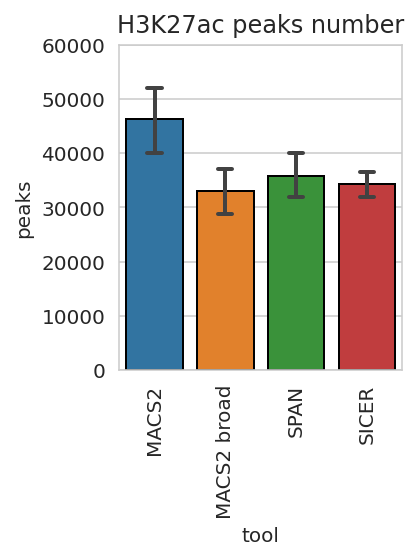

In [339]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(0, 60_000)
ax.title.set_text('H3K27ac peaks number')
plt.tight_layout()
plt.show()

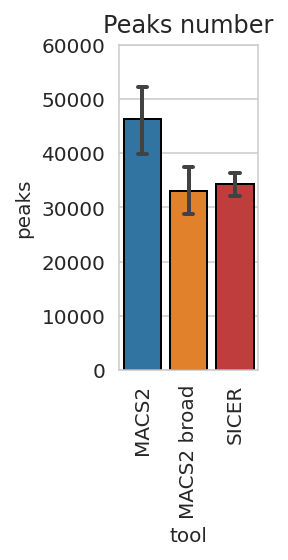

In [336]:
plt.figure(figsize=(2, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks number')
ax.set_ylim(0, 60_000)
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/peaks_no_span.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [319]:
DNASE = {
    ('GM12878', 'rep1') : GSE26320_PATH_HG38 + '/dnaseq/GM12878_rep1_DNAseq_hg38_ENCFF759OLD.bed',
    ('GM12878', 'rep2'): GSE26320_PATH_HG38 + '/dnaseq/GM12878_rep2_DNAseq_hg38_ENCFF338SAU.bed',
    ('H1', 'rep1') : GSE26320_PATH_HG38 + '/dnaseq/H1_rep1_DNAseq_hg38_ENCFF983UCL.bed',
    ('HMEC', 'rep1') : GSE26320_PATH_HG38 + '/dnaseq/HMEC_rep1_DNAseq_hg38_ENCFF687TIG.bed',
    ('HSMM', 'rep1') : GSE26320_PATH_HG38 + '/dnaseq/HSMM_rep1_DNAseq_hg38_ENCFF647RNC.bed',
    ('HSMM', 'rep2') : GSE26320_PATH_HG38 + '/dnaseq/HSMM_rep2_DNAseq_hg38_ENCFF711DSC.bed',
    ('HepG2', 'rep1') : GSE26320_PATH_HG38 + '/dnaseq/HepG2_rep1_DNAseq_hg38_ENCFF453AEP.bed',
    ('HepG2', 'rep2') : GSE26320_PATH_HG38 + '/dnaseq/HepG2_rep2_DNAseq_hg38_ENCFF897NME.bed',
    ('Huvec', 'rep1') : GSE26320_PATH_HG38 + '/dnaseq/Huvec_rep1_DNAseq_hg38_ENCFF080VVT.bed',
    ('Huvec', 'rep2') : GSE26320_PATH_HG38 + '/dnaseq/Huvec_rep2_DNAseq_hg38_ENCFF887HZL.bed',
    ('NHEK', 'rep1') : GSE26320_PATH_HG38 + '/dnaseq/NHEK_rep1_DNAseq_hg38_ENCFF011WVC.bed',
    ('NHEK', 'rep2') : GSE26320_PATH_HG38 + '/dnaseq/NHEK_rep2_DNAseq_hg38_ENCFF358VOS.bed',
    ('NHLF', 'rep1') : GSE26320_PATH_HG38 + '/dnaseq/NHLF_rep1_DNAseq_hg38_ENCFF645AAM.bed',
    ('NHLF', 'rep2') : GSE26320_PATH_HG38 + '/dnaseq/NHLF_rep2_DNAseq_hg38_ENCFF641BGM.bed'
}

for (cell, rep), dnase_file in DNASE.items():
    print(cell, rep, lines(dnase_file))

GM12878 rep1 50260
GM12878 rep2 36160
H1 rep1 38200
HMEC rep1 42766
HSMM rep1 373422
HSMM rep2 139955
HepG2 rep1 71330
HepG2 rep2 130520
Huvec rep1 176052
Huvec rep2 81353
NHEK rep1 51482
NHEK rep2 83639
NHLF rep1 298161
NHLF rep2 75432


In [322]:
print('Load lengths')
ts = []
for (c, r), dnase_file in DNASE.items():
    t = pd.read_csv(dnase_file, sep='\t', header=None)
    t = t.sample(min(len(t), 10_000)).copy()
    t = pd.DataFrame(dict(length=t[2]-t[1]))
    t['cell'] = c
    t['replicate'] = r 
    t['tool'] = 'DNAse'
    ts.append(t)
for cell, rep, file, tool in tqdm(zip(df_fdr_peaks['cell'], df_fdr_peaks['replicate'], df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

length   cell replicate         tool
301707     361   HMEC      rep2        MACS2
101284     140   NHEK      rep1        DNAse
400718     749  HepG2      rep2  MACS2 broad
663472    2480   HSMM      rep1         SPAN
700387    1009   NHLF      rep2         SPAN
270000    1114   NHLF      rep1        MACS2
131750     171   NHLF      rep2        DNAse
290509     611   NHEK      rep1        MACS2
147407    1892  HepG2      rep2        MACS2
258364     417   NHEK      rep2        MACS2

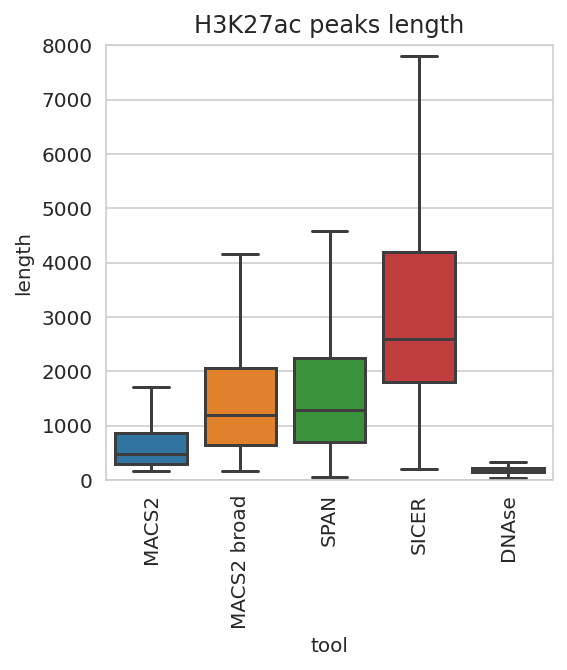

In [329]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='tool', y='length', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=TOOLS,
                        showfliers=False)
ax.title.set_text('H3K27ac peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 8000])
plt.show()

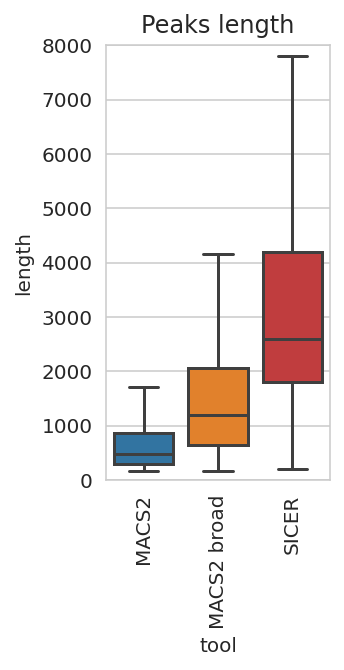

In [337]:
plt.figure(figsize=(2, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='tool', y='length', ax=ax,
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SICER'],
                        showfliers=False)
ax.title.set_text('Peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 8000])
plt.show()

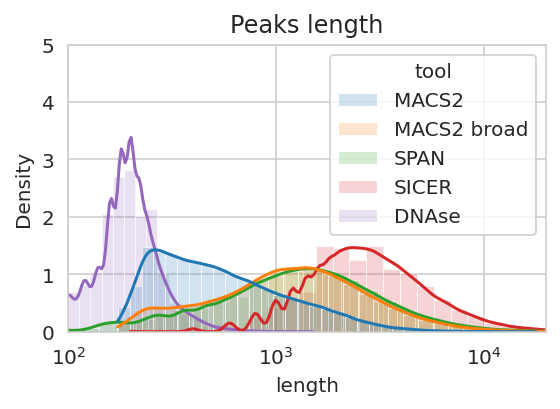

In [324]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=35, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=TOOLS)
g_results.set(xscale='log')
g_results.set_ylim(0, 5)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

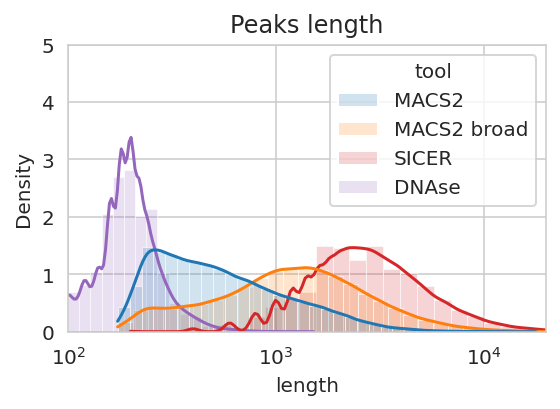

In [325]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=35, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'DNAse'])
g_results.set(xscale='log')
g_results.set_ylim(0, 5)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_lengths_nospan.pdf', bbox_inches='tight', dpi=300)
plt.show()

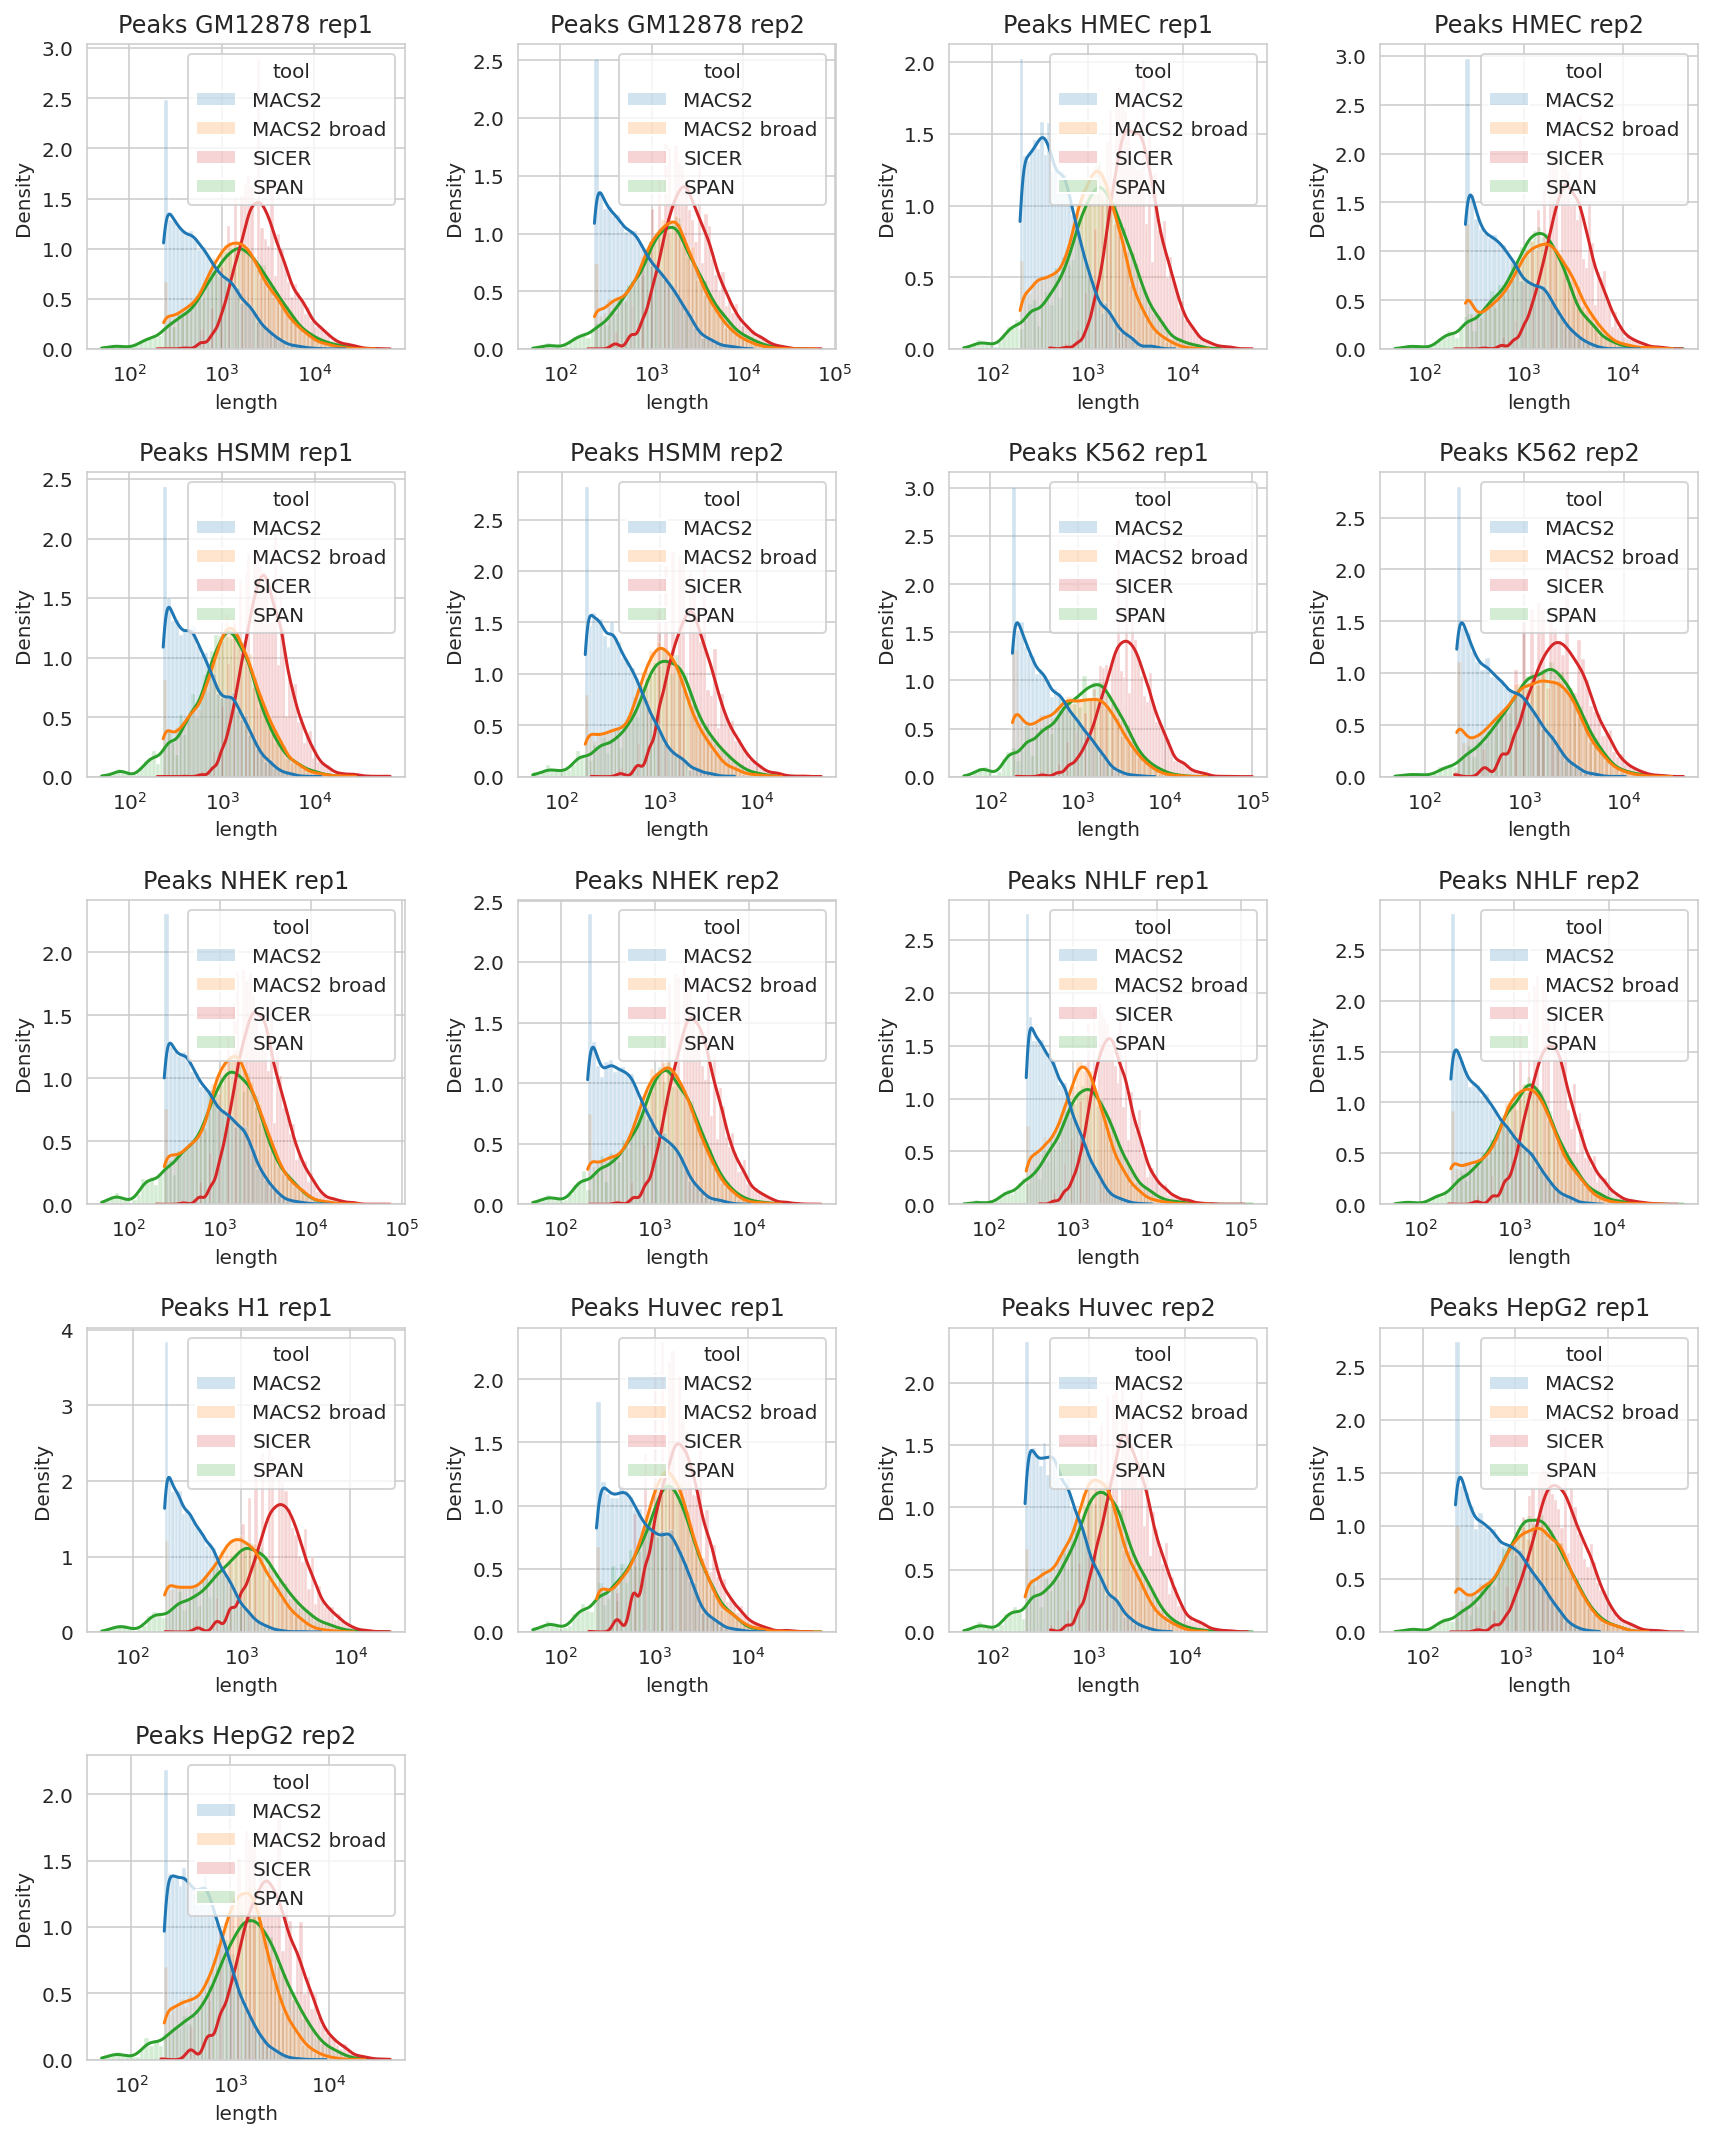

In [282]:
import math
experiments = [(c, r) for c, r in product(GSE26320_CELLS, GSE26320_REPS)
               if sum((t['cell'] == c) & (t['replicate'] == r)) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, (c, r) in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c} {r}')
    g_results = sns.histplot(data=t[(t['cell'] == c) & (t['replicate']==r)],
                             x='length', hue='tool', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=TOOLS)
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_lengths_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [277]:
t = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    t.append((tool, coverage))
t = pd.DataFrame(data=t, columns=['tool', 'coverage'])
t.sample(3)

0it [00:00, ?it/s]

tool  coverage
8         MACS2  45253954
23  MACS2 broad  16654351
51         SPAN  82905486

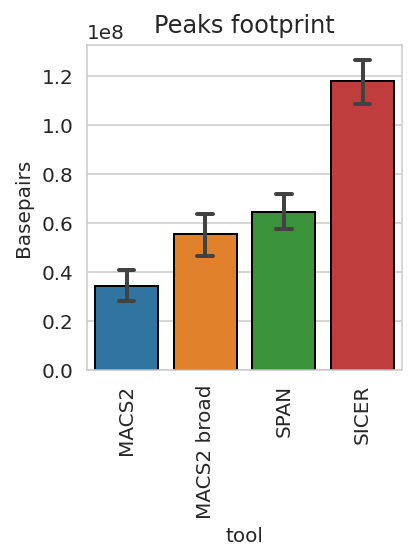

In [27]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=t, x='tool', y='coverage', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks footprint')
ax.set_ylabel('Basepairs')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Difference between narrow and broad peaks

In [213]:
! mkdir -p {GSE26320_PATH_HG38}/union

perc_ratio_df = pd.DataFrame(
    columns=['cell', 'replicate', 'length', 'tool', 'overlap_span_peaks', 'overlap_tool_peaks'], 
    dtype=object
)

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['cell', 'replicate', 'length', 'tool', 'peaks'], dtype=object)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    # Ignore bad quality tracks for now
    if c in ['NHLF', 'Huvec', 'HepG2']:
        continue
    
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    print(c, r)
    t = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K27ac') &
                     (df_fdr_peaks['cell'] == c) &
                     (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    try:
        t_span = sorted_file(t[t['tool'] == 'SPAN']['file'].values[0])
        t_macs2 = sorted_file(t[t['tool'] == 'MACS2']['file'].values[0])
        t_macs2broad = sorted_file(t[t['tool'] == 'MACS2 broad']['file'].values[0])
        t_sicer = sorted_file(t[t['tool'] == 'SICER']['file'].values[0])
        # Prepare total overlap
        # print(f'bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}')
        union_path = f'{GSE26320_PATH_HG38}/union/H3K27ac_{c}_{r}.bed'        
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            # Prepare SPAN percentage
            ! bedtools intersect -wa -u -a {t_span} -b {sorted_file(tf)} > {t_span}-perc
            # print('SPAN')
            # ! wc -l {t_span}-perc
            span_cols = len(pd.read_csv(f'{t_span}-perc', sep='\t', header=None, nrows=1).columns)
            # print('SPAN cols', span_cols)
            peak_lengths = bedl(f'{t_span}-perc')
            tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
            tl['name'] = 'SPAN'
            tl['cell'] = c
            tl['length'] = percentage_name
            perc_peaks_df.loc[len(perc_peaks_df)] = (c, r, percentage_name, 'SPAN', len(peak_lengths))
            perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

            for tool, file in [('MACS2', t_macs2), ('MACS2 broad', t_macs2broad), ('SICER', t_sicer)]:
                # Prepare tool percentage peaks
                ! bedtools intersect -wa -u -a {file} -b {sorted_file(tf)} > {file}-perc
                # print(tool)
                # ! wc -l {file}-perc
                peak_lengths = bedl(f'{file}-perc')
                tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
                tl['name'] = tool
                tl['cell'] = c
                tl['length'] = percentage_name
                perc_peaks_df.loc[len(perc_peaks_df)] = (c, r, percentage_name, tool, len(peak_lengths))
                perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))
                
                ! bedtools intersect -a {t_span}-perc -b {file}-perc -wa -wb > {tf2}
                # print('Overlap')
                # ! wc -l {tf2}
                overlap = pd.read_csv(tf2, sep='\t', header=None)
                overlap_span_peaks = len(overlap.groupby([0, 1, 2]).count())
                overlap_tool_peaks = len(overlap.groupby([span_cols, span_cols + 1, span_cols + 2]).count())
                perc_ratio_df.loc[len(perc_ratio_df)] = (c, r, percentage_name, tool, overlap_span_peaks, overlap_tool_peaks)
    except Exception as e:
        print(e)

display(perc_ratio_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
H1 rep1
H1 rep2


cell replicate    length         tool  overlap_span_peaks  \
147  NHEK      rep2  80%-100%        MACS2                9999   
61   HSMM      rep1    0%-20%  MACS2 broad                3726   
132  NHEK      rep1  80%-100%        MACS2               11869   

     overlap_tool_peaks  
147               25193  
61                 3725  
132               24863

peak_lengths         name  cell    length
1078969           824        MACS2  K562  80%-100%
943582           3066  MACS2 broad  K562   60%-80%
1468482           221  MACS2 broad    H1   40%-60%

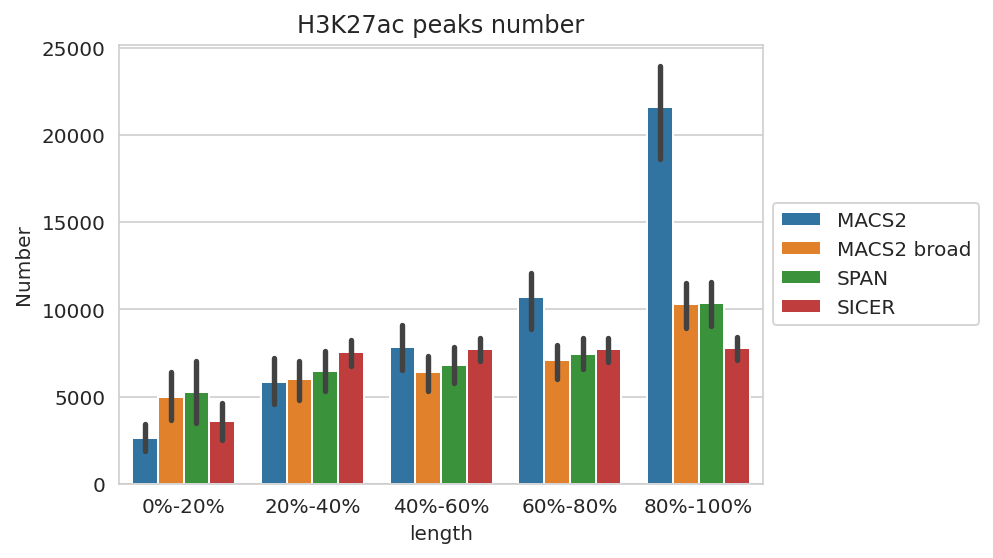

In [326]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.barplot(data=perc_peaks_df, 
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K27ac peaks number')
g_results.axes.set_ylabel('Number')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_peaks_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()

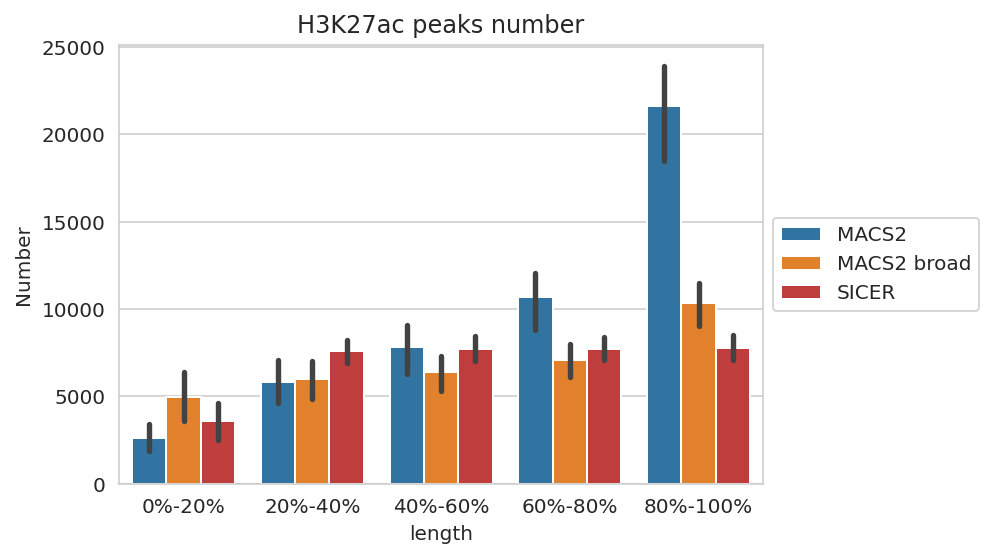

In [327]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.barplot(data=perc_peaks_df,
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K27ac peaks number')
g_results.axes.set_ylabel('Number')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_peaks_percentile_no_span.pdf', bbox_inches='tight', dpi=300)
plt.show()

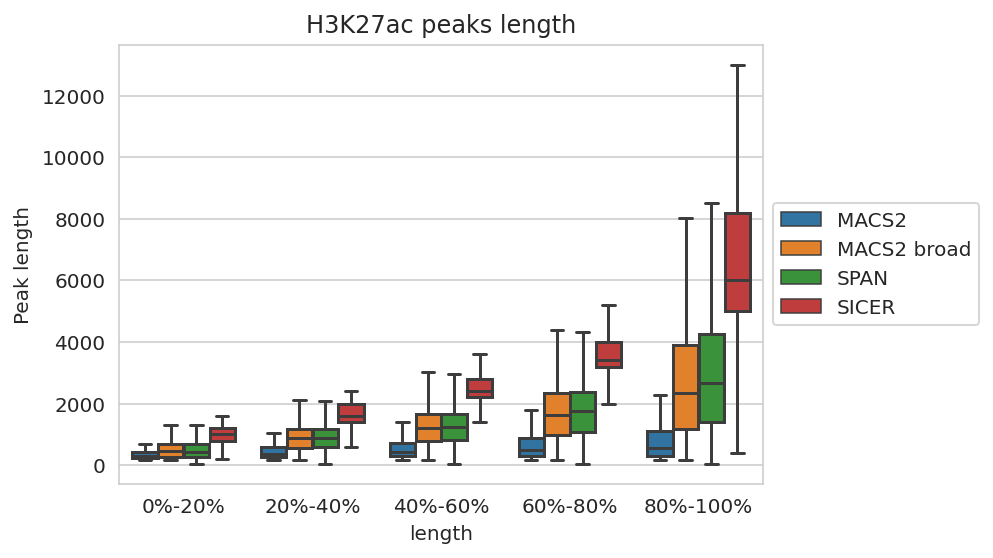

In [215]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_len_df, x='length', y='peak_lengths', ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K27ac peaks length')
g_results.axes.set_ylabel('Peak length')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_peak_length_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()

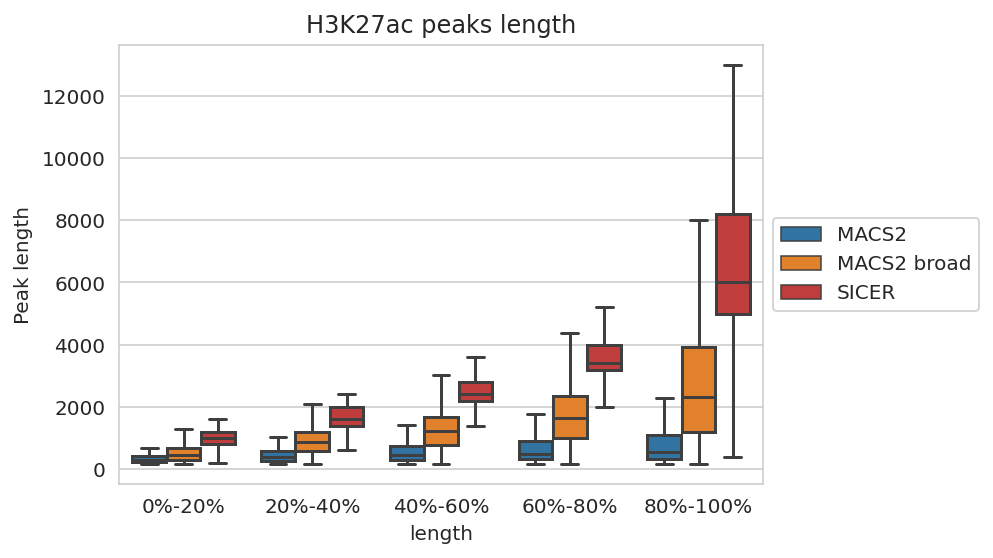

In [328]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_len_df, x='length', y='peak_lengths', ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K27ac peaks length')
g_results.axes.set_ylabel('Peak length')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_peak_length_percentile_no_span.pdf', bbox_inches='tight', dpi=300)
plt.show()

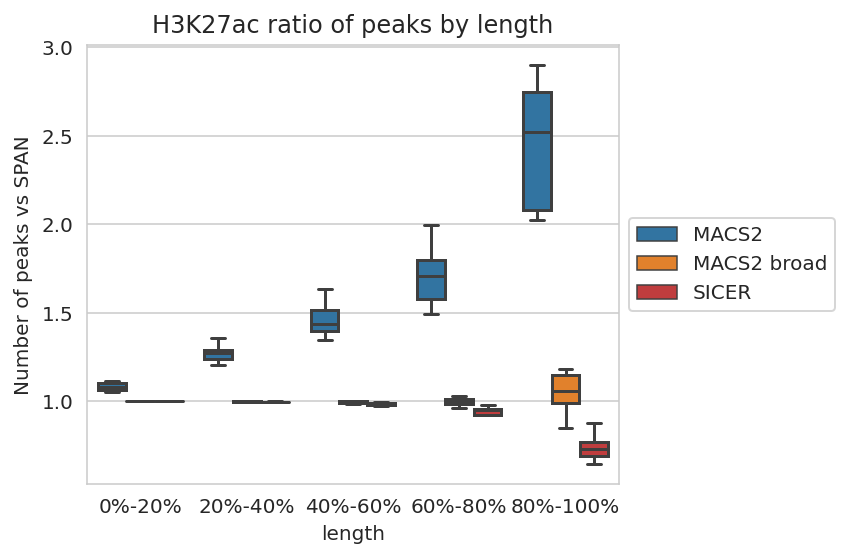

In [216]:
perc_ratio_df['tool_to_span'] = [d(t, s) for s, t in
                                 zip(perc_ratio_df['overlap_span_peaks'], perc_ratio_df['overlap_tool_peaks'])]

plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_ratio_df, x='length', y='tool_to_span', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K27ac ratio of peaks by length')
g_results.axes.set_ylabel('Number of peaks vs SPAN')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_ratios_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Consistency analysis between replicates

In [217]:
reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks1_overlap_len',
                                     'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

tf = tempfile.mktemp()

tools = list(sorted(set(df_fdr_peaks['tool'])))
for c, m in tqdm(product(GSE26320_CELLS, GSE26320_MODIFICATIONS)):
    # Ignore bad quality tracks for now
    if c in ['NHLF', 'Huvec', 'HepG2']:
        continue
    
    print(c, m)
    tm = df_fdr_peaks[(df_fdr_peaks['cell'] == c) & (df_fdr_peaks['modification'] == m)]
    reps = list(sorted(set(tm['replicate'])))
    for tool in tools:
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                if len(t1) == 0 or len(t2) == 0:
                    continue
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                peaks1_len = int(bedl(file1).sum())
                peaks2 = t2['peaks'].values[0]
                peaks2_len = int(bedl(file2).sum())
                !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                overlap1_len = overlap2_len = int(last_col(tf).sum())

                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     overlap1, overlap1_len, overlap2, overlap2_len)
reps_overlap.sample(5)

0it [00:00, ?it/s]

GM12878 H3K27ac
HMEC H3K27ac
HSMM H3K27ac
K562 H3K27ac
NHEK H3K27ac
H1 H3K27ac


modification  cell   tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
11      H3K27ac  HSMM   SPAN  rep1  rep2   38858    60035458   49653   
6       H3K27ac  HMEC  SICER  rep1  rep2   36689   146221711   35171   
10      H3K27ac  HSMM  SICER  rep1  rep2   36868   135797932   41796   
14      H3K27ac  K562  SICER  rep1  rep2   26929   126863271   26159   
8       H3K27ac  HSMM  MACS2  rep1  rep2   57283    45253954   55891   

    peaks2_len  peaks1_overlap  peaks1_overlap_len  peaks2_overlap  \
11    75247739           35783            52546651           35349   
6    125860429           29507            97145881           30184   
10   119226404           32977            95863895           34070   
14    78015441           20573            65754683           22617   
8     27656881           34979            23639134           46904   

    peaks2_overlap_len  
11            52546651  
6             97145881  
10            95863895  
14            65754683  
8             23639134

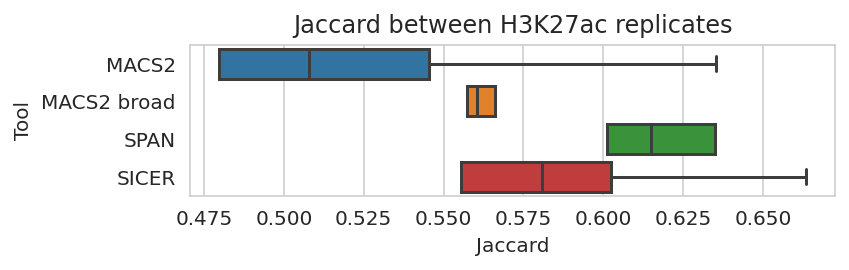

In [223]:
reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks1_overlap_len'])
]

plt.figure(figsize=(6, 2))

g_result = sns.boxplot(data=reps_overlap, y='tool', x='jaccard',
                       palette=TOOLS_PALETTE,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False)
ax = g_result.axes
ax.set_title('Jaccard between H3K27ac replicates')
ax.set_xlabel('Jaccard')
ax.set_ylabel('Tool')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_replicates.pdf', bbox_inches='tight', dpi=300)
plt.show()

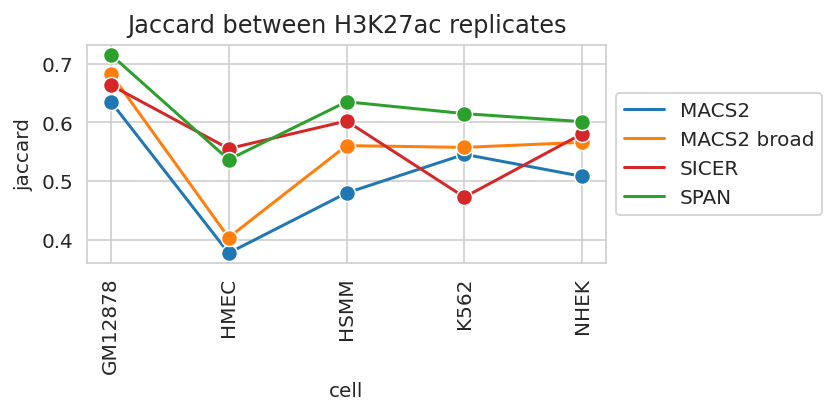

In [262]:
plt.figure(figsize=(6, 3))
g_results = sns.lineplot(data=reps_overlap,
                         x='cell', y='jaccard', hue='tool',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar='se', marker='o', markersize=8)
g_results.axes.title.set_text(f'Jaccard between H3K27ac replicates')
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_results.axes.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_replicates_detailed.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [224]:
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

jaccard_macs2 = reps_overlap[reps_overlap['tool'] == 'MACS2']['jaccard'].values
jaccard_macs2broad = reps_overlap[reps_overlap['tool'] == 'MACS2 broad']['jaccard'].values
jaccard_sicer = reps_overlap[reps_overlap['tool'] == 'SICER']['jaccard'].values
jaccard_span = reps_overlap[reps_overlap['tool'] == 'SPAN']['jaccard'].values

print(wilcoxon(jaccard_span, jaccard_macs2))
print(wilcoxon(jaccard_span, jaccard_macs2broad))
print(wilcoxon(jaccard_span, jaccard_sicer))

print(mannwhitneyu(jaccard_span, jaccard_macs2))
print(mannwhitneyu(jaccard_span, jaccard_macs2broad))
print(mannwhitneyu(jaccard_span, jaccard_sicer))

WilcoxonResult(statistic=0.0, pvalue=0.0625)
WilcoxonResult(statistic=0.0, pvalue=0.0625)
WilcoxonResult(statistic=1.0, pvalue=0.125)
MannwhitneyuResult(statistic=20.0, pvalue=0.15079365079365079)
MannwhitneyuResult(statistic=18.0, pvalue=0.30952380952380953)
MannwhitneyuResult(statistic=17.0, pvalue=0.42063492063492064)


In [225]:
reps_overlap['peak1_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks1_overlap'], reps_overlap['peaks1'])]
reps_overlap['peak2_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks2_overlap'], reps_overlap['peaks2'])]

reps_overlap['peak1_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks1_overlap_len'], reps_overlap['peaks1_len'])
]
reps_overlap['peak2_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks2_overlap_len'], reps_overlap['peaks2_len'])
]
reps_overlap.sample(5)

modification     cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
11      H3K27ac     HSMM         SPAN  rep1  rep2   38858    60035458   49653   
12      H3K27ac     K562        MACS2  rep1  rep2   53699    30912259   39718   
3       H3K27ac  GM12878         SPAN  rep1  rep2   34842    78383419   31050   
2       H3K27ac  GM12878        SICER  rep1  rep2   32861   124120539   31704   
13      H3K27ac     K562  MACS2 broad  rep1  rep2   39486    56837860   26701   

    peaks2_len  peaks1_overlap  peaks1_overlap_len  peaks2_overlap  \
11    75247739           35783            52546651           35349   
12    28716588           34489            21048451           32012   
3     70478499           28027            62083430           28245   
2    108935496           27915            92957832           28755   
13    48217642           23289            37598885           22635   

    peaks2_overlap_len   jaccard  peak1_overlap_fraction  \
11            52546651  0.635108                0.920866   
12            21048451  0.545574                0.642265   
3             62083430  0.715424                0.804403   
2             92957832  0.663519                0.849487   
13            37598885  0.557379                0.589804   

    peak2_overlap_fraction  peak1_overlap_fraction_len  \
11                0.711921                    0.875260   
12                0.805982                    0.680910   
3                 0.909662                    0.792048   
2                 0.906983                    0.748932   
13                0.847721                    0.661511   

    peak2_overlap_fraction_len  
11                    0.698315  
12                    0.732972  
3                     0.880885  
2                     0.853329  
13                    0.779774

In [226]:
t = pd.concat([
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak1_overlap_fraction', 'peak1_overlap_fraction_len']
    ].copy().rename(dict(peak1_overlap_fraction='overlap', peak1_overlap_fraction_len='overlap_len'), axis=1),
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak2_overlap_fraction', 'peak2_overlap_fraction_len']
    ].copy().rename(dict(peak2_overlap_fraction='overlap', peak2_overlap_fraction_len='overlap_len'), axis=1)
]).reset_index(drop=True)
# t

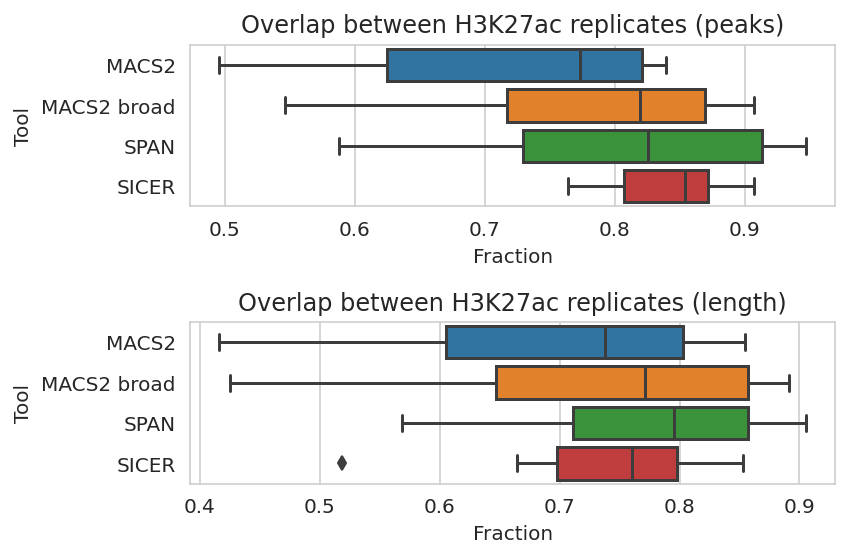

In [227]:
plt.figure(figsize=(6, 4))
axs = [plt.subplot(2, 1, i + 1) for i in range(2)]

g_result = sns.boxplot(data=t, y='tool', x='overlap', ax=axs[0],
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       palette=TOOLS_PALETTE)
ax = g_result.axes
ax.set_title('Overlap between H3K27ac replicates (peaks)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

g_result = sns.boxplot(data=t, y='tool', x='overlap_len', ax=axs[1],
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       palette=TOOLS_PALETTE)
ax = g_result.axes
ax.set_title('Overlap between H3K27ac replicates (length)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

plt.tight_layout()
plt.show()

In [231]:
reps_overlap['cell'].unique()

array(['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK'], dtype=object)

In [253]:
reps_overlap[reps_overlap['cell'] == 'K562'][['cell', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len', 'peaks1_overlap_len']]

cell         tool   jaccard  peaks1  peaks2  peaks1_len  peaks2_len  \
12  K562        MACS2  0.545574   53699   39718    30912259    28716588   
13  K562  MACS2 broad  0.557379   39486   26701    56837860    48217642   
14  K562        SICER  0.472634   26929   26159   126863271    78015441   
15  K562         SPAN  0.614859   26221   20535    44725752    40684709   

    peaks1_overlap_len  
12            21048451  
13            37598885  
14            65754683  
15            32520098

# Consistency between replicates by length

In [207]:
import tempfile
from itertools import product

perc_reps_overlap = pd.DataFrame(
    columns=['modification', 'cell', 'tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)


for c in tqdm(GSE26320_CELLS):
    # Ignore bad quality tracks for now
    if c in ['NHLF', 'Huvec', 'HepG2']:
        continue
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()
    tf3 = tempfile.mktemp()

    print(c)
    try:
        rep_tool_map = {}
        for r, tool in product(GSE26320_REPS, ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']):
            t = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K27ac') &
                             (df_fdr_peaks['cell'] == c) &
                             (df_fdr_peaks['replicate'] == r) &
                             (df_fdr_peaks['tool'] == tool)]
            if len(t) > 0:
                rep_tool_map[(r, tool)] = sorted_file(t['file'].values[0])
        # Prepare global overlap 
        tr1_macs2 = rep_tool_map[('rep1', 'MACS2')]
        tr1_macs2broad = rep_tool_map[('rep1', 'MACS2 broad')]
        tr1_span = rep_tool_map[('rep1', 'SPAN')]
        tr1_sicer = rep_tool_map[('rep1', 'SICER')]
        tr2_macs2 = rep_tool_map[('rep2', 'MACS2')]
        tr2_macs2broad = rep_tool_map[('rep2', 'MACS2 broad')]
        tr2_span = rep_tool_map[('rep2', 'SPAN')]
        tr2_sicer = rep_tool_map[('rep2', 'SICER')]
        # Prepare global overlap
        ! bedtools multiinter -i {tr1_macs2} {tr1_macs2broad} {tr1_span} {tr1_sicer} \
                {tr2_macs2} {tr2_macs2broad} {tr2_span} {tr2_sicer} > {tf}
        ! bedtools merge -i {tf} > {tf2}
        t = pd.read_csv(tf2, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            # Prepare tools percentage
            for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
                r1file = rep_tool_map[('rep1', tool)]
                r2file = rep_tool_map[('rep2', tool)]
                ! bedtools intersect -wa -u -a {r1file} -b {sorted_file(tf)} > {r1file}-perc
                ! bedtools intersect -wa -u -a {r2file} -b {sorted_file(tf)} > {r2file}-perc
                r1file = f'{r1file}-perc'
                r2file = f'{r2file}-perc'
                r1_peaks = lines(r1file)
                r2_peaks = lines(r2file)
                r1_len = int(bedl(r1file).sum())
                r2_len = int(bedl(r2file).sum())
                !bedtools intersect -a {r1file} -b {r2file} -wa -u > {tf3}
                overlap1 = lines(tf3)
                !bedtools intersect -b {r1file} -a {r2file} -wa -u > {tf3}
                overlap2 = lines(tf3)
                !bedtools intersect -a {r1file} -b {r2file} -wo > {tf3}
                overlap1_len = overlap2_len = int(last_col(tf3).sum())
                perc_reps_overlap.loc[len(perc_reps_overlap)] = \
                    ('H3K27ac', c, tool, percentage_name, r1_peaks, r1_len, r2_peaks, r2_len,
                    overlap1, overlap1_len, overlap2, overlap2_len)

    except Exception as e:
        print(e)

perc_reps_overlap.sample(5)

  0%|          | 0/9 [00:00<?, ?it/s]

GM12878
HMEC
HSMM
K562
NHEK
H1
('rep2', 'MACS2')


modification     cell         tool length_percentage  peaks1  peaks1_len  \
13      H3K27ac  GM12878  MACS2 broad           60%-80%    6902    12914688   
49      H3K27ac     HSMM  MACS2 broad           40%-60%    8719    10015206   
8       H3K27ac  GM12878        MACS2           40%-60%    6696     4323877   
56      H3K27ac     HSMM        MACS2          80%-100%   25024    25199995   
0       H3K27ac  GM12878        MACS2            0%-20%    2130      854773   

    peaks2  peaks2_len  peaks1_overlap  peaks1_overlap_len  peaks2_overlap  \
13    6401    11226546            6028             9634646            6061   
49    7298     6528136            6618             5440643            6657   
8     5851     3763632            4749             2816500            4761   
56   28135    16734164           17175            15080710           25214   
0     1728      711148             953              356992             930   

    peaks2_overlap_len  
13             9634646  
49             5440643  
8              2816500  
56            15080710  
0               356992

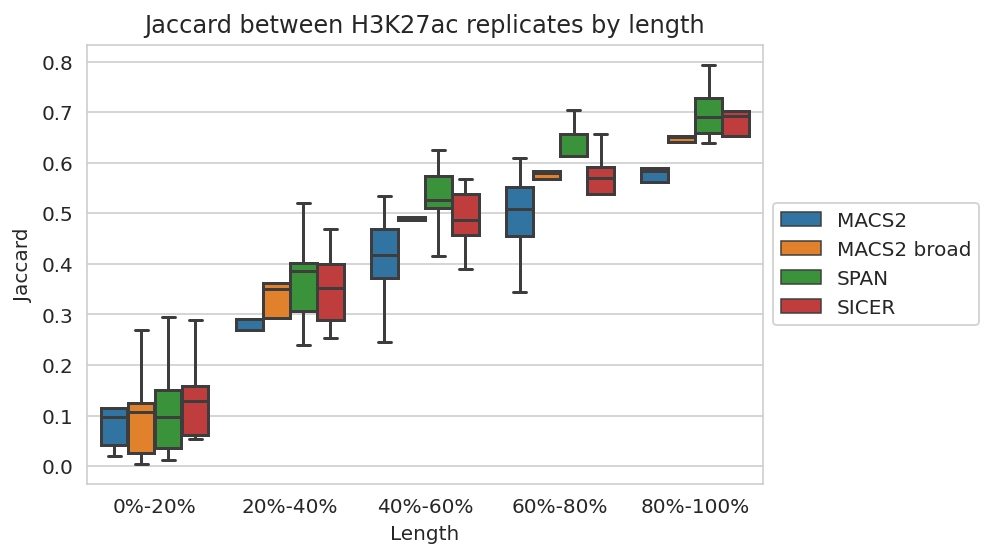

In [256]:
perc_reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(perc_reps_overlap['peaks1_len'], 
                          perc_reps_overlap['peaks2_len'], perc_reps_overlap['peaks1_overlap_len'])
]

plt.figure(figsize=(7, 4))

g_result = sns.boxplot(data=perc_reps_overlap, 
                       x='length_percentage', y='jaccard',
                       hue='tool',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False)
ax = g_result.axes
ax.set_title('Jaccard between H3K27ac replicates by length')
ax.set_xlabel('Length')
ax.set_ylabel('Jaccard')
# Put a legend to the right of the current axis
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_replicates_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [209]:
# for cell in GSE26320_CELLS:
#     t = perc_reps_overlap[(perc_reps_overlap['cell'] == cell)]
#     if len(t) == 0:
#         continue
#     print(cell)
#     plt.figure(figsize=(5, 3))
#     g_result = sns.boxplot(data=t,
#                        x='length_percentage', y='jaccard',
#                        hue='tool',
#                        palette=TOOLS_PALETTE,
#                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
#                        showfliers=False)
#     ax = g_result.axes
#     ax.set_title('Jaccard between H3K27ac replicates by length')
#     ax.set_xlabel('Length')
#     ax.set_ylabel('Jaccard')
#     # Put a legend to the right of the current axis
#     g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     # plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_replicates_by_length.pdf', bbox_inches='tight', dpi=300)
#     plt.show()

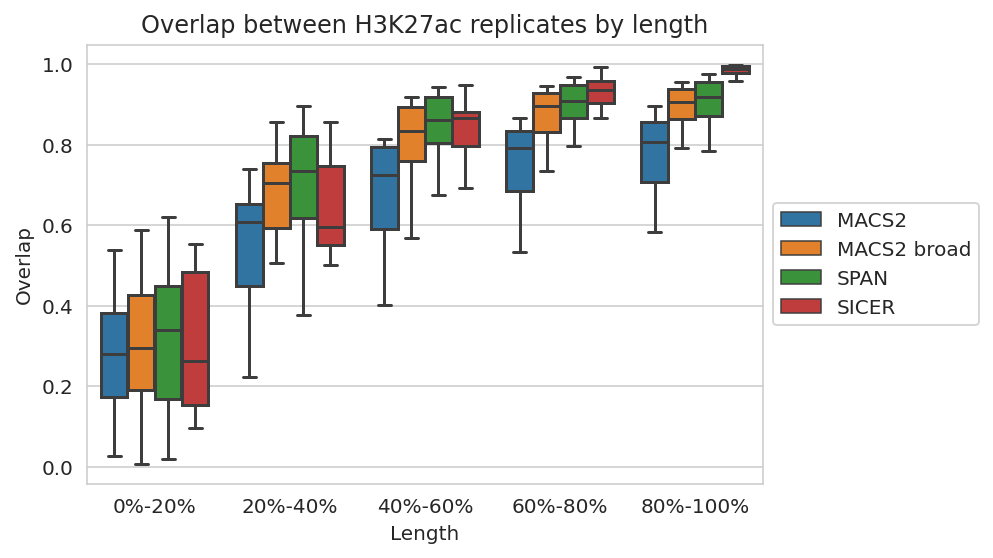

In [211]:
perc_reps_overlap['overlap1'] = [d(o, p) for o, p in
                                 zip(perc_reps_overlap['peaks1_overlap'], perc_reps_overlap['peaks1'])]
perc_reps_overlap['overlap2'] = [d(o, p) for o, p in
                                 zip(perc_reps_overlap['peaks2_overlap'], perc_reps_overlap['peaks2'])]

t = perc_reps_overlap[['tool', 'length_percentage', 'overlap1', 'overlap2']].copy().melt(
    id_vars=['tool', 'length_percentage'], value_vars=['overlap1', 'overlap2'])


plt.figure(figsize=(7, 4))

g_result = sns.boxplot(data=t, x='length_percentage', y='value',
                       hue='tool',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False)
ax = g_result.axes
ax.set_title('Overlap between H3K27ac replicates by length')
ax.set_xlabel('Length')
ax.set_ylabel('Overlap')
# Put a legend to the right of the current axis
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_replicates_overlap_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

GM12878


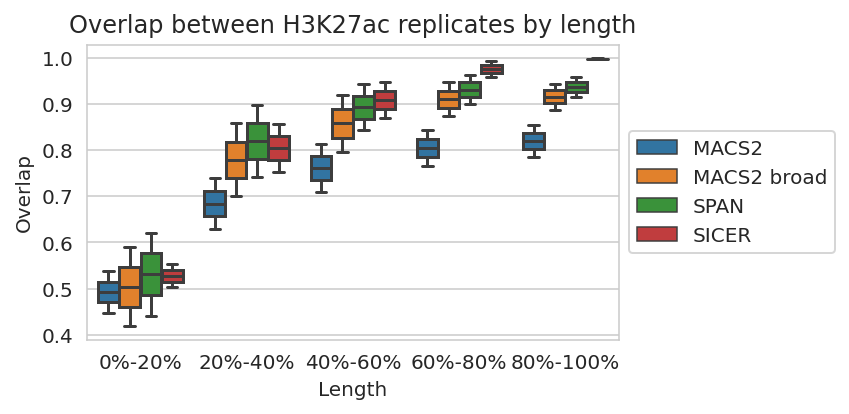

HMEC


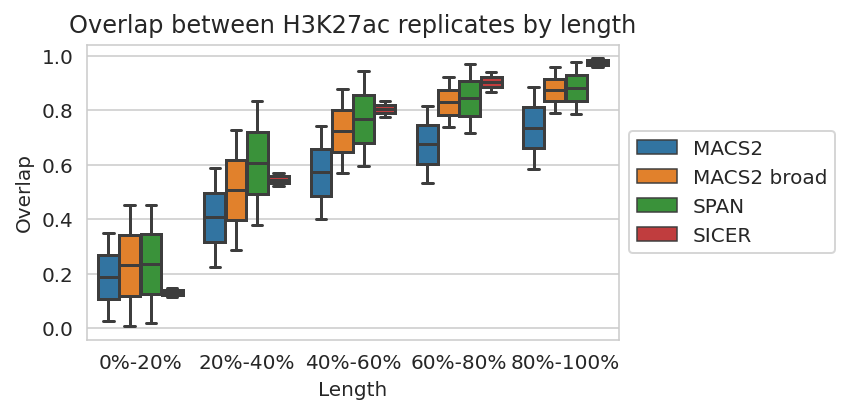

HSMM


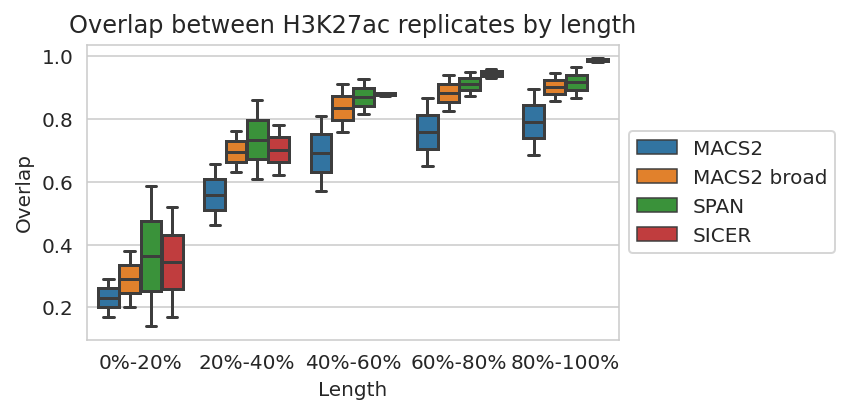

K562


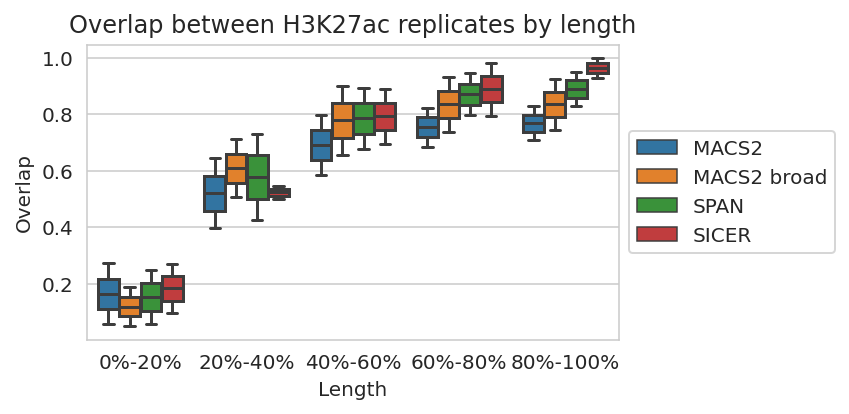

NHEK


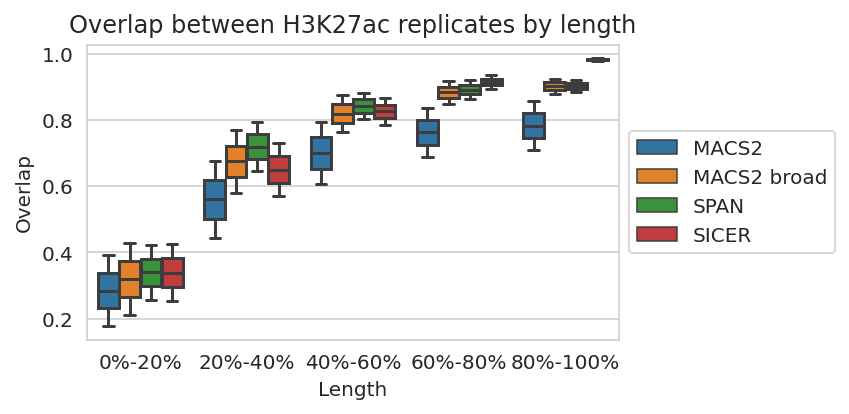

In [283]:
for cell in GSE26320_CELLS:
    t = perc_reps_overlap[(perc_reps_overlap['cell'] == cell)
    ][['tool', 'length_percentage', 'overlap1', 'overlap2']].copy().melt(
        id_vars=['tool', 'length_percentage'], value_vars=['overlap1', 'overlap2'])
    if len(t) == 0:
        continue
    print(cell)
    plt.figure(figsize=(6, 3))

    g_result = sns.boxplot(data=t, x='length_percentage', y='value',
                       hue='tool',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False)
    ax = g_result.axes
    ax.set_title('Overlap between H3K27ac replicates by length')
    ax.set_xlabel('Length')
    ax.set_ylabel('Overlap')
    # Put a legend to the right of the current axis
    g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    # plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_replicates_overlap_by_length.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Overlap H3K27ac vs DHS

In [288]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name',
             'peaks', 'peaks_len', 'dnase', 'dnase_len',
             'peaks_overlap', 'peaks_overlap_len', 'dnase_overlap', 'dnase_overlap_len'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) in DNASE:
        dnase_file = sorted_file(DNASE[c, r])
        dnase_peaks = lines(dnase_file)
        dnase_len = int(bedl(dnase_file).sum())
        print(f'Cell {c} dnase {dnase_peaks}')
    else:
        dnase_file, dnase_peaks, dnase_len = None, 0, 0
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        if dnase_file is not None:
            !bedtools intersect -a {peaks_file} -b {dnase_file} -wa -u > {tf}
            peaks_overlap = lines(tf)
            !bedtools intersect -b {peaks_file} -a {dnase_file} -wa -u > {tf}
            dnase_overlap = lines(tf)
            !bedtools intersect -a {peaks_file} -b {dnase_file} -wo > {tf}
            peaks_overlap_len = dnase_overlap_len = int(last_col(tf).sum())
        else:
            peaks_overlap, peaks_overlap_len, dnase_overlap, dnase_overlap_len = 0, 0, 0, 0

        bench_df.loc[len(bench_df)] = (c, r, tool,
                                       peaks, peaks_len,
                                       dnase_peaks, dnase_len,
                                       peaks_overlap, peaks_overlap_len,
                                       dnase_overlap, dnase_overlap_len)
bench_df

0it [00:00, ?it/s]

GM12878 rep1
Cell GM12878 dnase 50260
GM12878 rep2
Cell GM12878 dnase 36160
HMEC rep1
Cell HMEC dnase 42766
HMEC rep2
HSMM rep1
Cell HSMM dnase 373422
HSMM rep2
Cell HSMM dnase 139955
K562 rep1
K562 rep2
NHEK rep1
Cell NHEK dnase 51482
NHEK rep2
Cell NHEK dnase 83639
NHLF rep1
Cell NHLF dnase 298161
NHLF rep2
Cell NHLF dnase 75432
H1 rep1
Cell H1 dnase 38200
H1 rep2
Huvec rep1
Cell Huvec dnase 176052
Huvec rep2
Cell Huvec dnase 81353
HepG2 rep1
Cell HepG2 dnase 71330
HepG2 rep2
Cell HepG2 dnase 130520


cell replicate         name  peaks  peaks_len   dnase  dnase_len  \
0   GM12878      rep1        MACS2  47290   41890163   50260   10309839   
1   GM12878      rep1         SPAN  34842   78383419   50260   10309839   
2   GM12878      rep1  MACS2 broad  31476   65449208   50260   10309839   
3   GM12878      rep1        SICER  32861  124120539   50260   10309839   
4   GM12878      rep2        MACS2  43917   38095017   36160    7121870   
..      ...       ...          ...    ...        ...     ...        ...   
63    HepG2      rep1        SICER  28360  112165840   71330   13145688   
64    HepG2      rep2        MACS2  26021   16705467  130520   24942571   
65    HepG2      rep2         SPAN  25775   54335027  130520   24942571   
66    HepG2      rep2  MACS2 broad  16682   25357410  130520   24942571   
67    HepG2      rep2        SICER  27516   89880684  130520   24942571   

    peaks_overlap  peaks_overlap_len  dnase_overlap  dnase_overlap_len  
0           18806            3962473          22443            3962473  
1           19858            6240033          28935            6240033  
2           18925            5871024          27357            5871024  
3           20870            6913116          31449            6913116  
4           14076            3197483          17727            3197483  
..            ...                ...            ...                ...  
63          21903            7396663          36342            7396663  
64          16500            3112655          21568            3112655  
65          21601            8873193          43062            8873193  
66          14539            5620458          27794            5620458  
67          24479           10798170          51512           10798170  

[68 rows x 11 columns]

In [289]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['dnase_overlap'], bench_df['dnase'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]

bench_df['precision_len'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap_len'], bench_df['peaks_len'])]
bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(bench_df['dnase_overlap_len'], bench_df['dnase_len'])]
bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(bench_df['sensitivity_len'], bench_df['precision_len'])]

bench_df['jaccard'] = [
    d(o, p + g - o)
    for p, g, o in zip(bench_df['peaks_len'], bench_df['dnase_len'], bench_df['dnase_overlap_len'])
]

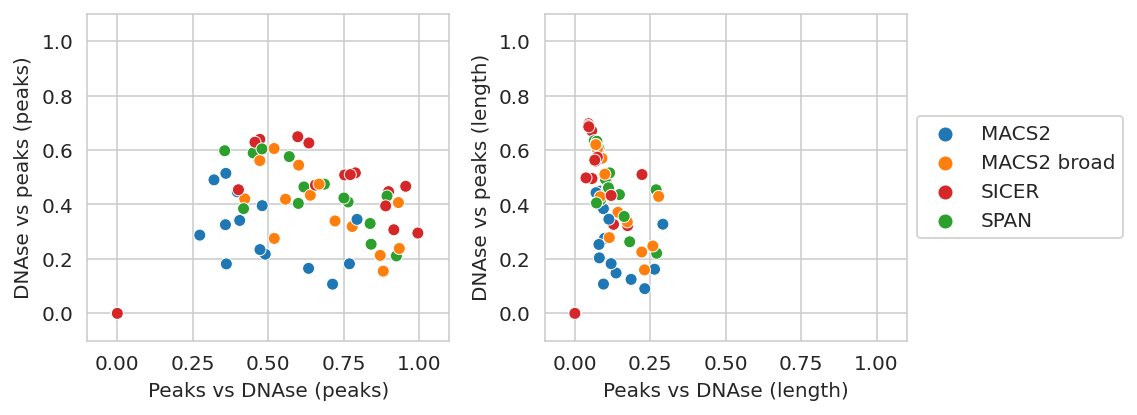

In [290]:
import seaborn as sns

plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

ax = axs[0]
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.set_xlabel('Peaks vs DNAse (peaks)')
g_results.axes.set_ylabel('DNAse vs peaks (peaks)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
ax.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=bench_df, x='precision_len', y='sensitivity_len', hue='name',
                            palette=TOOLS_PALETTE, ax=ax,
                            hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'])
g_results.axes.set_xlabel('Peaks vs DNAse (length)')
g_results.axes.set_ylabel('DNAse vs peaks (length)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [291]:
ts = []
for name in bench_df['name'].unique():
    tn = bench_df[bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))

t = pd.concat(ts).reset_index(drop=True)
del ts

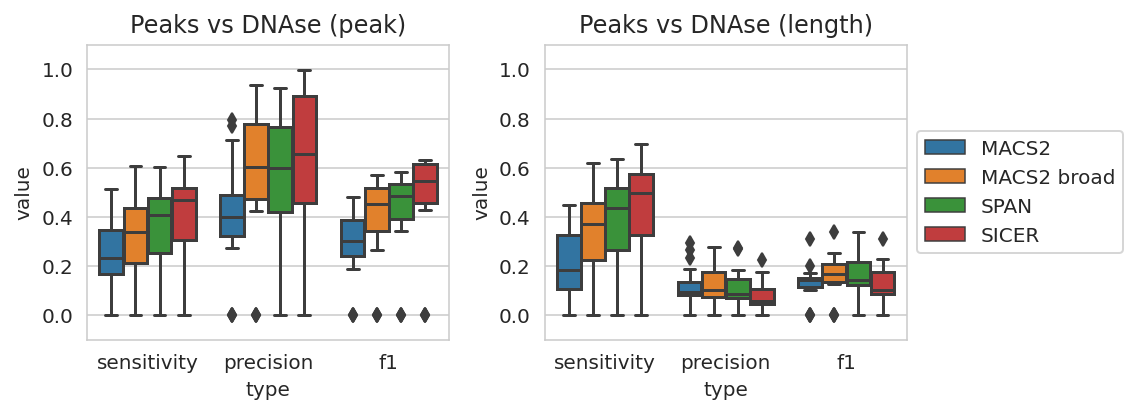

In [292]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, benchmark in enumerate(['peak', 'length']):
    g_results = sns.boxplot(data=t[t['benchmark'] == benchmark], x='type', y='value', hue='name',
                            ax=axs[i],
                            palette=TOOLS_PALETTE,
                            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax = g_results.axes
    ax.set_title(f'Peaks vs DNAse ({benchmark})')
    # Put a legend to the right of the current axis
    if i == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

# Overlap H3K27ac diff vs DHS

In [294]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name',
             'peaks', 'peaks_len', 'dnase', 'dnase_len',
             'peaks_overlap', 'peaks_overlap_len', 'dnase_overlap', 'dnase_overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) in DNASE:
        dnase_file = sorted_file(DNASE[c, r])
        dnase_peaks = lines(dnase_file)
        dnase_len = int(bedl(dnase_file).sum())
    else:
        dnase_file, dnase_peaks, dnase_len = None, 0, 0
        
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') &
                     (df_fdr_peaks['modification'] == 'H3K27ac') &
                     (df_fdr_peaks['cell'] == c) &
                     (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            if dnase_file is not None:
                !bedtools intersect -a {tf} -b {dnase_file} -wa -u > {tf2}
                peaks_overlap = lines(tf2)
                !bedtools intersect -b {tf} -a {dnase_file} -wa -u > {tf2}
                dnase_overlap = lines(tf2)
                !bedtools intersect -a {tf} -b {dnase_file} -wo > {tf2}
                peaks_overlap_len = dnase_overlap_len = int(last_col(tf2).sum())
            else:
                peaks_overlap, peaks_overlap_len, dnase_overlap, dnase_overlap_len = 0, 0, 0, 0 
                
            diff_bench_df.loc[len(diff_bench_df)] = (c, r, name, peaks, peaks_len,
                                                     dnase_peaks, dnase_len,
                                                     peaks_overlap, peaks_overlap_len,
                                                     dnase_overlap, dnase_overlap_len)

display(diff_bench_df.sample(5))

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell replicate                name  peaks  peaks_len  dnase  dnase_len  \
36   K562      rep1        SPAN - MACS2   1901    1150508      0          0   
52   NHEK      rep1        SPAN - SICER   4361    1286917  51482    9293675   
49   NHEK      rep1        MACS2 - SPAN    190      48799  51482    9293675   
46   K562      rep2        SPAN - SICER     76      61510      0          0   
87  Huvec      rep2  MACS2 broad - SPAN     15       8592  81353   14955999   

    peaks_overlap  peaks_overlap_len  dnase_overlap  dnase_overlap_len  
36              0                  0              0                  0  
52            553              65350            564              65350  
49              8                352              8                352  
46              0                  0              0                  0  
87              9               1554              9               1554

In [295]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['dnase_overlap'], diff_bench_df['dnase'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                       for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

diff_bench_df['precision_len'] = [
    d(a, b) for a, b in zip(diff_bench_df['peaks_overlap_len'], diff_bench_df['peaks_len'])
]
diff_bench_df['sensitivity_len'] = [
    d(a, b) for a, b in zip(diff_bench_df['dnase_overlap_len'], diff_bench_df['dnase_len'])
]
diff_bench_df['f1_len'] = [
    d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
    for s, p in zip(diff_bench_df['sensitivity_len'], diff_bench_df['precision_len'])
]

diff_bench_df['jaccard'] = [
    d(o, p + g - o)
    for p, g, o
    in zip(diff_bench_df['peaks_len'], diff_bench_df['dnase_len'], diff_bench_df['dnase_overlap_len'])
]

In [296]:
full_bench_df = pd.concat([bench_df, diff_bench_df]).reset_index(drop=True)
full_bench_df.sample(5)

cell replicate          name  peaks  peaks_len   dnase  dnase_len  \
0    GM12878      rep1         MACS2  47290   41890163   50260   10309839   
21      HSMM      rep2          SPAN  49653   75247739  139955   25466401   
60     HepG2      rep1         MACS2  48652   40342410   71330   13145688   
147    Huvec      rep1  MACS2 - SPAN     29       7095  176052   43893262   
169    HepG2      rep2  SICER - SPAN   3942    6896058  130520   24942571   

     peaks_overlap  peaks_overlap_len  dnase_overlap  dnase_overlap_len  \
0            18806            3962473          22443            3962473   
21           37988           11109606          57254           11109606   
60           23368            4546362          28212            4546362   
147             14               2292             16               2292   
169           2265             525503           2788             525503   

     precision  sensitivity        f1  precision_len  sensitivity_len  \
0     0.397674     0.446538  0.420692       0.094592         0.384339   
21    0.765070     0.409089  0.533116       0.147640         0.436246   
60    0.480309     0.395514  0.433807       0.112694         0.345844   
147   0.482759     0.000091  0.000182       0.323044         0.000052   
169   0.574581     0.021361  0.041190       0.076203         0.021069   

       f1_len   jaccard  
0    0.151819  0.082145  
21   0.220617  0.123985  
60   0.169995  0.092893  
147  0.000104  0.000052  
169  0.033010  0.016782

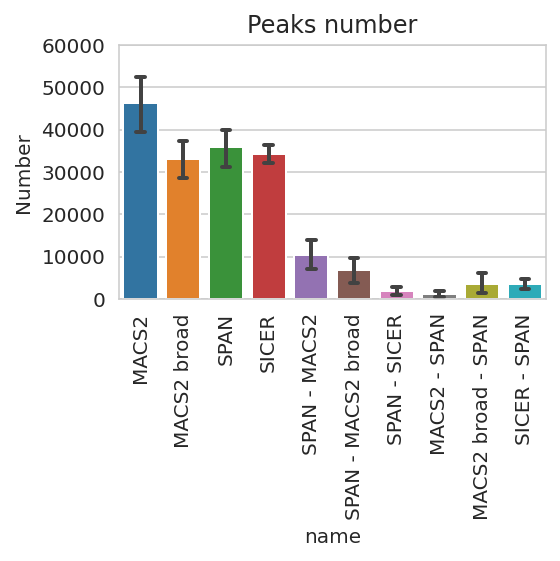

In [297]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_bench_df, x='name', y='peaks',
                        capsize=.2, errwidth=2, ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(top=60_000)  # Limit for visual aesthetics
ax.set_ylabel('Number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

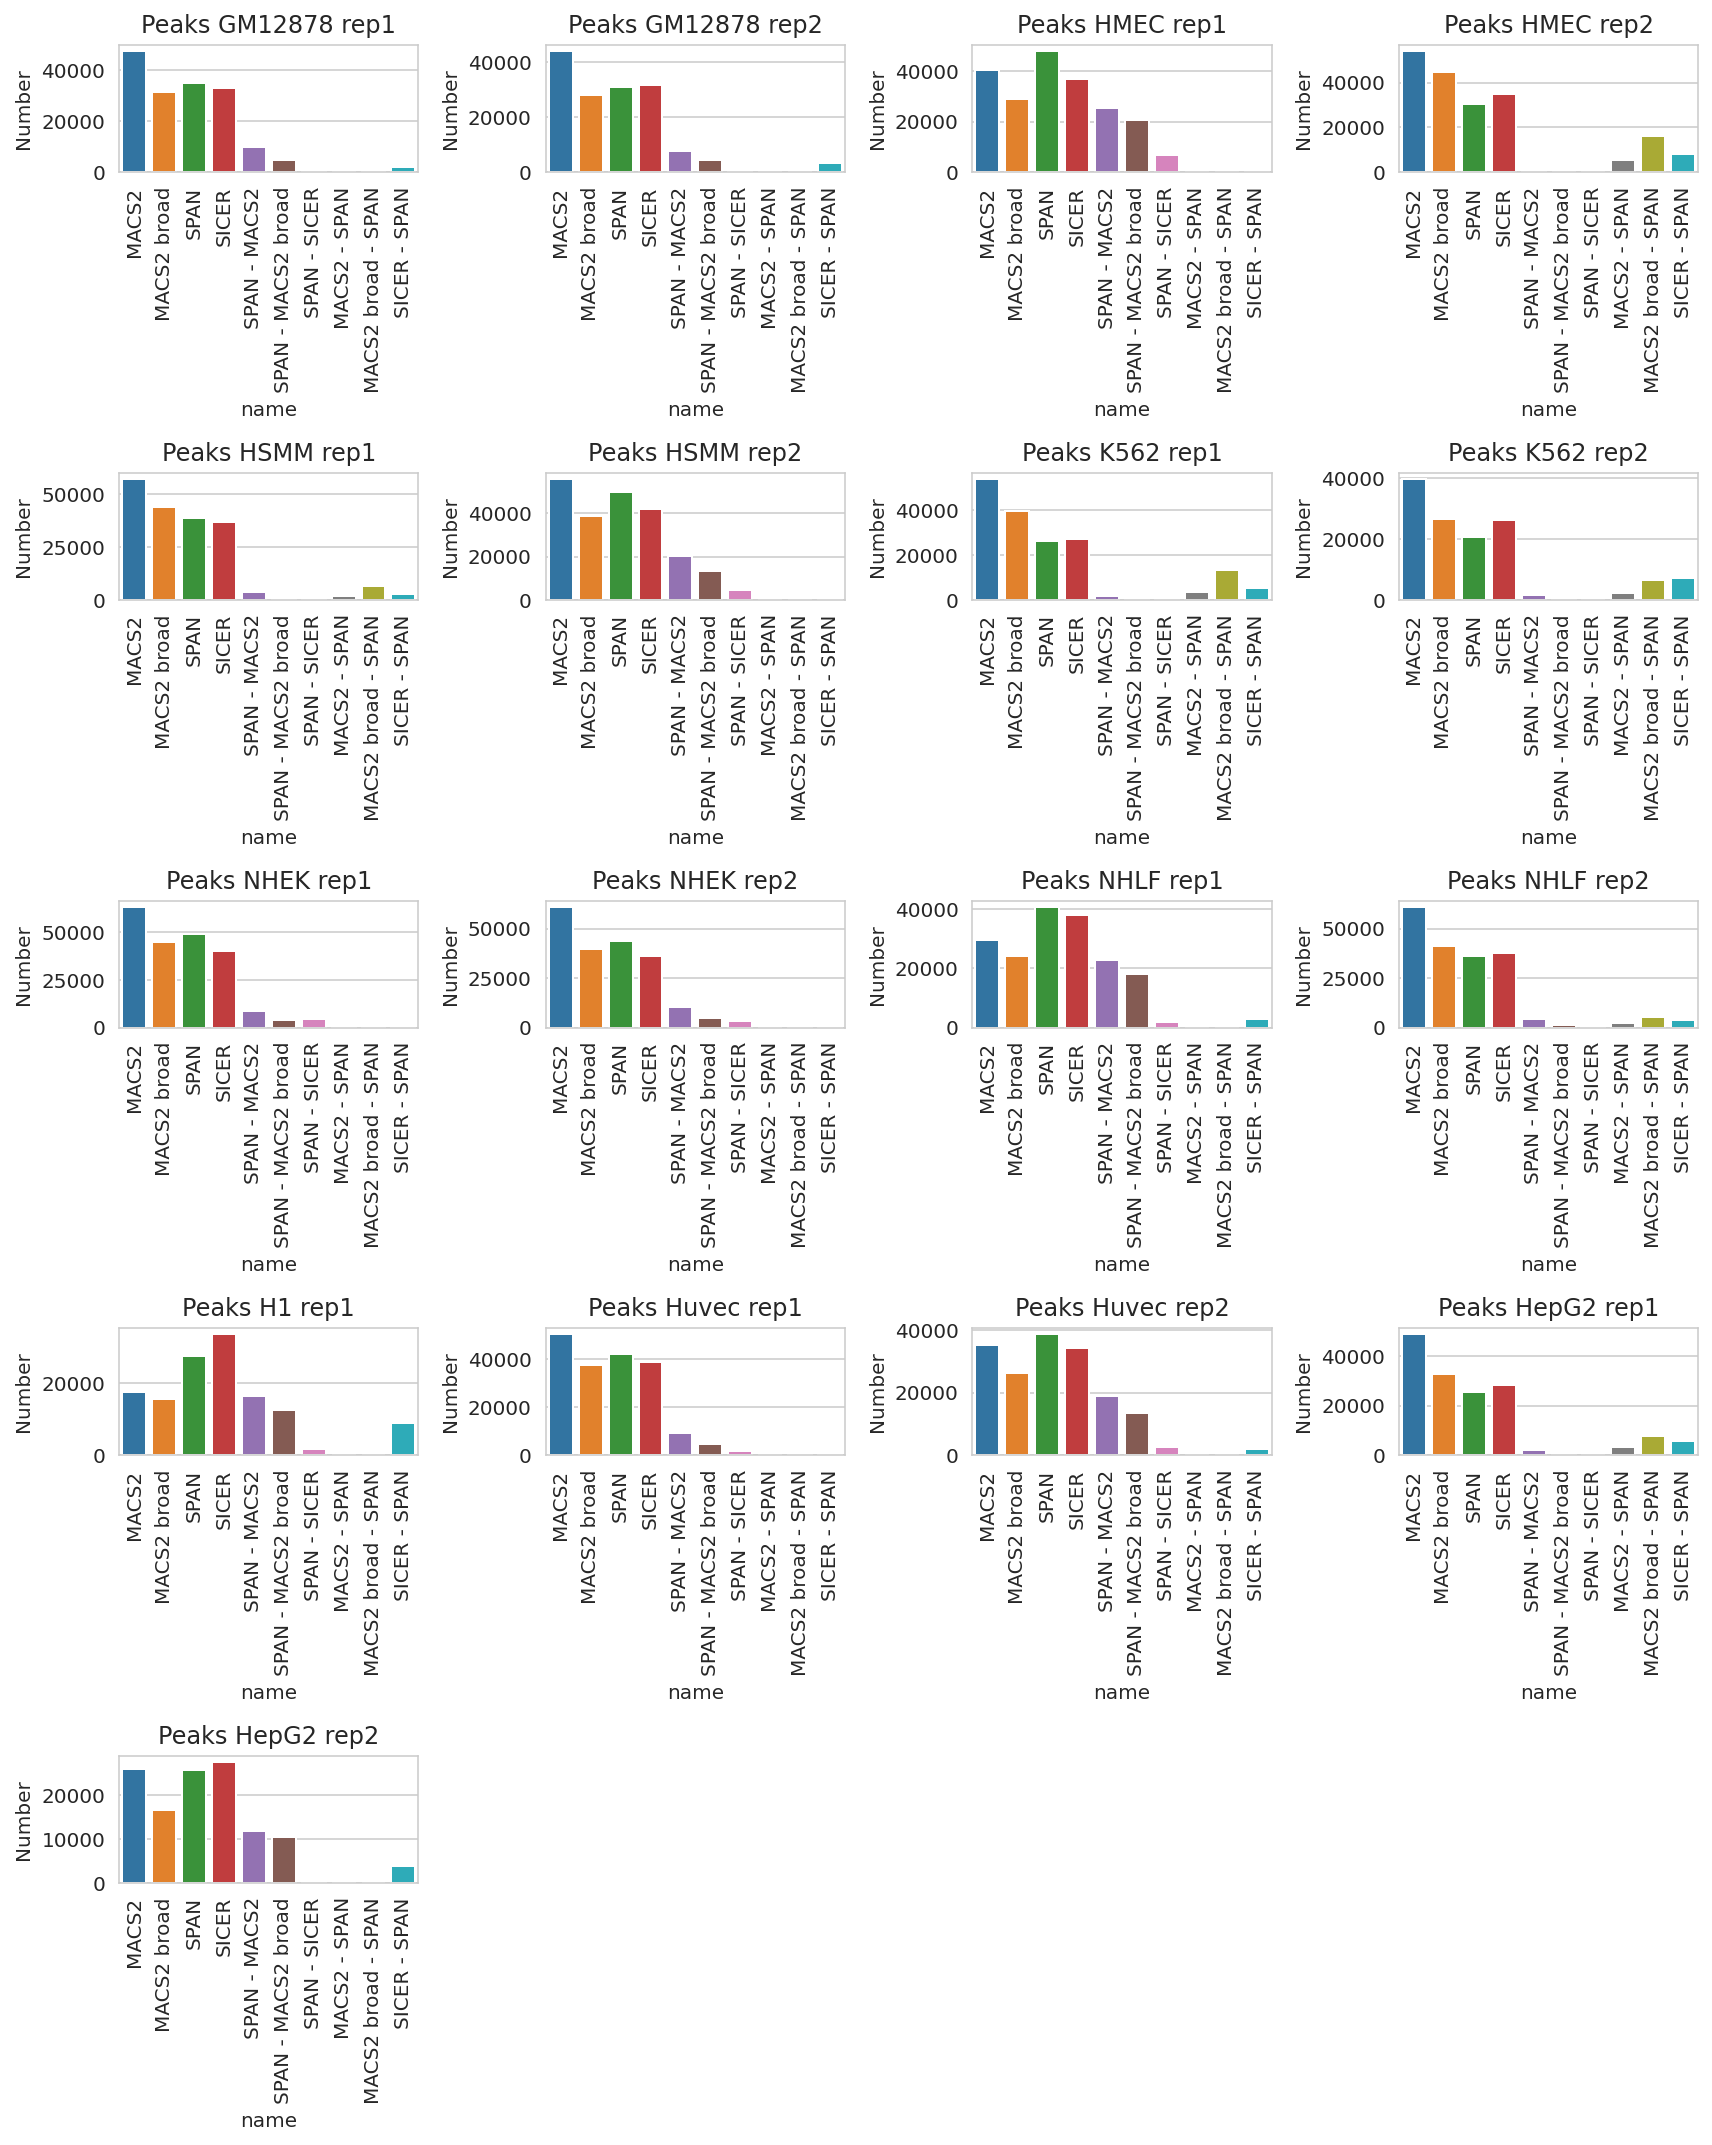

In [298]:
import math
experiments = [(c, r) for c, r in product(GSE26320_CELLS, GSE26320_REPS)
               if sum((full_bench_df['cell'] == c) & (full_bench_df['replicate'] == r)) > 0]
nrows = int(math.ceil(math.sqrt(len(experiments))))
ncols = int(math.ceil(len(experiments) / nrows))
plt.figure(figsize=(3 * ncols, 3 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
for i, (c, r) in enumerate(experiments):
    ax = axs[i]
    ax.title.set_text(f'Peaks {c} {r}')
    g_results = sns.barplot(data=full_bench_df[(full_bench_df['cell'] == c) & (full_bench_df['replicate']==r)],
                            x='name', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ]
                            )
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_peaks_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Save benchmark df

In [178]:
full_bench_df.to_csv(GSE26320_PATH_HG38 + '/H3K27ac_full_bench_df.csv.gz', index=False, compression='gzip')

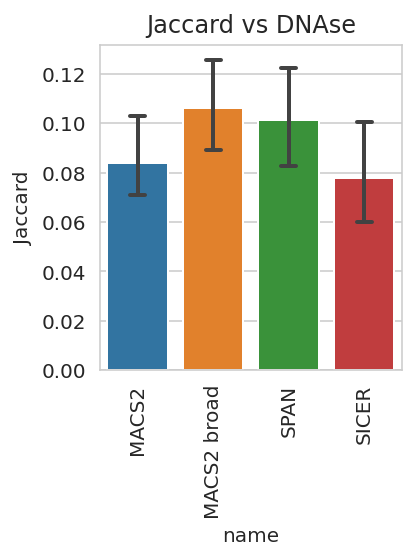

In [179]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Jaccard vs DNAse')
g_results = sns.barplot(data=full_bench_df, x='name', y='jaccard',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_jaccard.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [31]:
ts = []
for name in full_bench_df['name'].unique():
    tn = full_bench_df[full_bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))
t = pd.concat(ts).reset_index(drop=True)
del ts

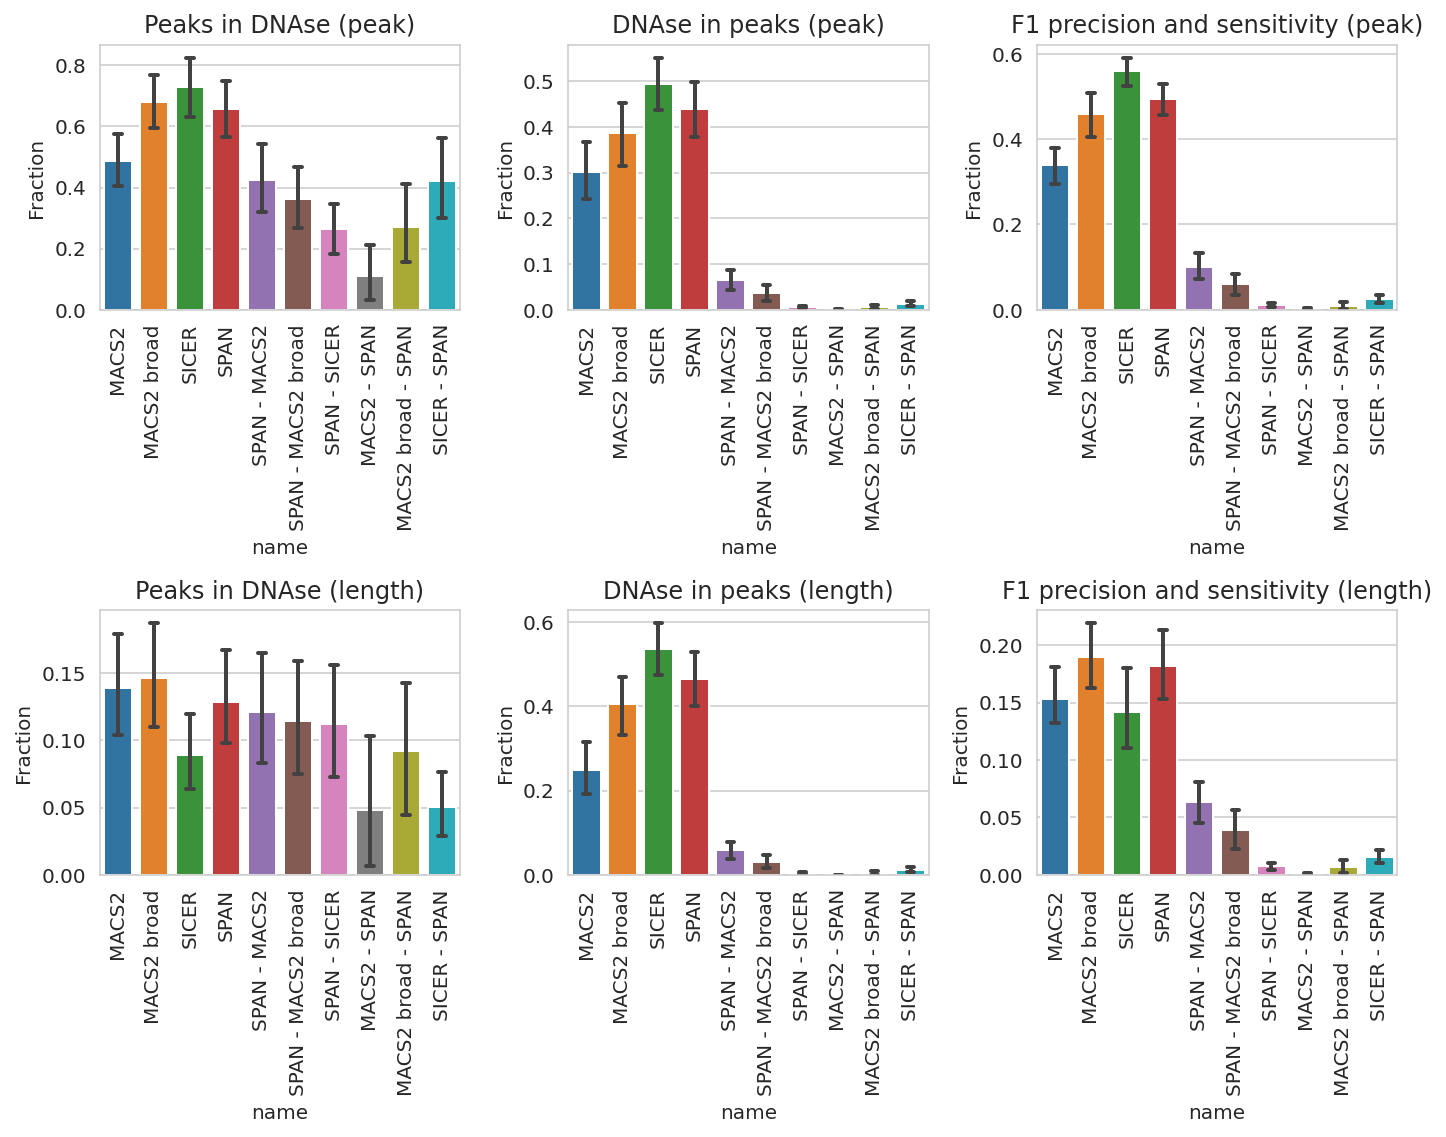

In [32]:
plt.figure(figsize=(10, 8))
axs = [plt.subplot(2, 3, i + 1) for i in range(6)]
for i, (benchmark, type) in enumerate(product(['peak', 'length'], ['precision', 'sensitivity', 'f1'])):
    ax = axs[i]
    if type == 'precision':
        ax.title.set_text(f'Peaks in DNAse ({benchmark})')
    elif type == 'sensitivity':
        ax.title.set_text(f'DNAse in peaks ({benchmark})')
    else:
        ax.title.set_text(f'F1 precision and sensitivity ({benchmark})')
    sns.barplot(data=t[(t['benchmark'] == benchmark) & (t['type'] == type)], x='name', y='value',
                capsize=.2, errwidth=2, ax=ax,
                order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

# Compare peaks to DNAse ratio

In [33]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

ratio_df = pd.DataFrame(columns=['cell', 'tool', 'dnase', 'peaks'], dtype=object)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in DNASE:
        continue
    dnase_file = sorted_file(DNASE[c, r])
    dnase_peaks = lines(dnase_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        dnase_cols = len(pd.read_csv(dnase_file, sep='\t', header=None, nrows=1).columns)
        !bedtools intersect -a {dnase_file} -b {peaks_file} -wa -wb > {tf}
        try:
            tf_overlap = pd.read_csv(tf, sep='\t', header=None)
            dnase_peaks = len(tf_overlap.groupby([0, 1, 2]).count())
            peaks = len(tf_overlap.groupby([dnase_cols, dnase_cols + 1, dnase_cols + 2]).count())
            ratio_df.loc[len(ratio_df)] = (c, tool, dnase_peaks, peaks)
        except:
            pass
ratio_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell         tool   dnase  peaks
0   GM12878         SPAN   28935  19858
1   GM12878        SICER   31449  20870
2   GM12878  MACS2 broad   27357  18925
3   GM12878        MACS2   22443  18806
4   GM12878         SPAN   21305  13984
5   GM12878        SICER   23104  14977
6   GM12878  MACS2 broad   20286  13320
7   GM12878        MACS2   17727  14076
8      HMEC         SPAN   25536  17034
9      HMEC        SICER   26880  16740
10     HMEC  MACS2 broad   17977  12289
11     HMEC        MACS2   12289  11101
12     HSMM         SPAN   78778  35951
13     HSMM        SICER  110165  36734
14     HSMM  MACS2 broad   88924  41316
15     HSMM        MACS2   67958  44079
16     HSMM         SPAN   57254  37988
17     HSMM        SICER   62583  37587
18     HSMM  MACS2 broad   44622  30094
19     HSMM        MACS2   30409  27407
20     NHEK         SPAN   31087  23434
21     NHEK        SICER   33389  23951
22     NHEK  MACS2 broad   31166  23352
23     NHEK        MACS2   26470  22819
24     NHEK         SPAN   38823  27054
25     NHEK        SICER   42505  27392
26     NHEK  MACS2 broad   36291  25393
27     NHEK        MACS2   28536  24822
28     NHLF         SPAN   75700  34321
29     NHLF        SICER   91537  34870
30     NHLF  MACS2 broad   46233  21270
31     NHLF        MACS2   31973  21192
32     NHLF         SPAN   30452  21864
33     NHLF        SICER   35531  24683
34     NHLF  MACS2 broad   31618  23144
35     NHLF        MACS2   24562  21936
36       H1         SPAN   14690  11521
37       H1        SICER   17337  13532
38       H1  MACS2 broad   10514   8158
39       H1        MACS2    6936   6325
40    Huvec         SPAN   75863  37783
41    Huvec        SICER   82154  37047
42    Huvec  MACS2 broad   71620  35169
43    Huvec        MACS2   60759  40023
44    Huvec         SPAN   38601  26488
45    Huvec        SICER   41965  26949
46    Huvec  MACS2 broad   27602  18950
47    Huvec        MACS2   19052  16639
48    HepG2         SPAN   30215  19184
49    HepG2        SICER   36342  21903
50    HepG2  MACS2 broad   33858  21840
51    HepG2        MACS2   28212  23368
52    HepG2         SPAN   43062  21601
53    HepG2        SICER   51512  24479
54    HepG2  MACS2 broad   27794  14539
55    HepG2        MACS2   21568  16500

In [34]:
ratio_df['dnase_to_peaks'] = ratio_df['dnase'] / ratio_df['peaks']
ratio_df.sort_values(by=['tool'], inplace=True)

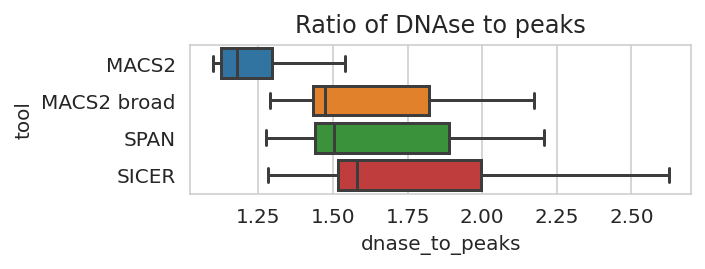

In [35]:
plt.figure(figsize=(5, 2))
ax = plt.axes()
g_results = sns.boxplot(data=ratio_df, x='dnase_to_peaks', y='tool', ax=ax,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('Ratio of DNAse to peaks')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_ratios.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Hg38 Top peaks overlap with DHS

In [36]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

benchmark_top_df = pd.DataFrame(
    columns=['cell', 'replicate', 'top', 'dnase', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in DNASE:
        continue
    dnase_file = sorted_file(DNASE[c, r])
    dnase_peaks = lines(dnase_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        t.sort_values(by=[8] if len(t.columns) >= 9 else [4], ascending=False, inplace=True)
        for top in np.linspace(1000, 15_000, 15):
            t.head(int(top)).sort_values(by=[0, 1]).to_csv(tf, sep='\t', index=False, header=None)
            tf = sorted_file(tf)
            peaks = lines(tf)
            ! bedtools intersect -a {tf} -b {dnase_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            ! bedtools intersect -b {tf} -a {dnase_file} -wa -u > {tf2}
            dnase_overlap = lines(tf2)
            benchmark_top_df.loc[len(benchmark_top_df)] = \
                (c, r, top, dnase_peaks, peaks_file, peaks, peaks_overlap, dnase_overlap, tool)

benchmark_top_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell replicate      top   dnase        peaks_file  peaks     pg  \
0    GM12878      rep1   1000.0   50260  /tmp/tmpu8v9yctl   1000    950   
1    GM12878      rep1   2000.0   50260  /tmp/tmpu8v9yctl   2000   1872   
2    GM12878      rep1   3000.0   50260  /tmp/tmpu8v9yctl   3000   2786   
3    GM12878      rep1   4000.0   50260  /tmp/tmpu8v9yctl   4000   3662   
4    GM12878      rep1   5000.0   50260  /tmp/tmpu8v9yctl   5000   4536   
..       ...       ...      ...     ...               ...    ...    ...   
835    HepG2      rep2  11000.0  130520  /tmp/tmph_t484zb  11000   9346   
836    HepG2      rep2  12000.0  130520  /tmp/tmph_t484zb  12000  10025   
837    HepG2      rep2  13000.0  130520  /tmp/tmph_t484zb  13000  10682   
838    HepG2      rep2  14000.0  130520  /tmp/tmph_t484zb  14000  11348   
839    HepG2      rep2  15000.0  130520  /tmp/tmph_t484zb  15000  11897   

        gp   tool  
0     2774   SPAN  
1     4765   SPAN  
2     6474   SPAN  
3     8007   SPAN  
4     9444   SPAN  
..     ...    ...  
835  14123  MACS2  
836  14911  MACS2  
837  15633  MACS2  
838  16371  MACS2  
839  16962  MACS2  

[840 rows x 9 columns]

In [37]:
benchmark_top_df['p'] = (benchmark_top_df['pg'] + benchmark_top_df['gp']) / 2
benchmark_top_df['precision'] = [d(x, y) for x, y in zip(benchmark_top_df['pg'], benchmark_top_df['peaks'])]
benchmark_top_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_top_df['gp'], benchmark_top_df['dnase'])]
benchmark_top_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in zip(benchmark_top_df['sensitivity'], benchmark_top_df['precision'])]
benchmark_top_df

cell replicate      top   dnase        peaks_file  peaks     pg  \
0    GM12878      rep1   1000.0   50260  /tmp/tmpu8v9yctl   1000    950   
1    GM12878      rep1   2000.0   50260  /tmp/tmpu8v9yctl   2000   1872   
2    GM12878      rep1   3000.0   50260  /tmp/tmpu8v9yctl   3000   2786   
3    GM12878      rep1   4000.0   50260  /tmp/tmpu8v9yctl   4000   3662   
4    GM12878      rep1   5000.0   50260  /tmp/tmpu8v9yctl   5000   4536   
..       ...       ...      ...     ...               ...    ...    ...   
835    HepG2      rep2  11000.0  130520  /tmp/tmph_t484zb  11000   9346   
836    HepG2      rep2  12000.0  130520  /tmp/tmph_t484zb  12000  10025   
837    HepG2      rep2  13000.0  130520  /tmp/tmph_t484zb  13000  10682   
838    HepG2      rep2  14000.0  130520  /tmp/tmph_t484zb  14000  11348   
839    HepG2      rep2  15000.0  130520  /tmp/tmph_t484zb  15000  11897   

        gp   tool        p  precision  sensitivity        f1  
0     2774   SPAN   1862.0   0.950000     0.055193  0.104325  
1     4765   SPAN   3318.5   0.936000     0.094807  0.172175  
2     6474   SPAN   4630.0   0.928667     0.128810  0.226240  
3     8007   SPAN   5834.5   0.915500     0.159312  0.271396  
4     9444   SPAN   6990.0   0.907200     0.187903  0.311323  
..     ...    ...      ...        ...          ...       ...  
835  14123  MACS2  11734.5   0.849636     0.108206  0.191964  
836  14911  MACS2  12468.0   0.835417     0.114243  0.200999  
837  15633  MACS2  13157.5   0.821692     0.119775  0.209074  
838  16371  MACS2  13859.5   0.810571     0.125429  0.217242  
839  16962  MACS2  14429.5   0.793133     0.129957  0.223322  

[840 rows x 13 columns]

In [38]:
def rgb2hex(color):
    r, g, b, _ = color
    return "#{0:02x}{1:02x}{2:02x}".format(int(r * 255), int(g * 255), int(b * 255))

PLOTLY_TOOLS_PALETTE = {k: rgb2hex(v) for k, v in TOOLS_PALETTE.items()}

In [39]:
import plotly.graph_objects as go

def plot_top(benchmark_top_df):
    tools_legend_shown = set()
    fig = go.Figure()

    for c, r, t in product(GSE26320_CELLS, GSE26320_REPS, df_fdr_peaks['tool'].unique()):
        dft = benchmark_top_df[(benchmark_top_df['cell'] == c) &
                               (benchmark_top_df['replicate'] == r) &
                               (benchmark_top_df['tool'] == t)]
        if len(dft) == 0:
            continue
        fig.add_trace(go.Scatter(
            x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
            hovertext=dft['cell'].astype(str) + ' ' + dft['replicate'].astype(str) + \
                      ' ' + dft['top'].astype(str) + ' ' + t,
            showlegend=t not in tools_legend_shown,
            marker_color=PLOTLY_TOOLS_PALETTE[t],
            opacity=0.5,
        ))
        tools_legend_shown.add(t)


    fig.update_xaxes(range=[-0.1, 1.1], title='Peaks overlapping dnase (sensitivity)')
    fig.update_yaxes(range=[-0.1, 1.1], title='Dnase overlapping peaks (precision)')

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=800,
        height=600,)
    fig.show()


In [40]:
plot_top(benchmark_top_df[(benchmark_top_df['cell'] == 'HepG2') & (benchmark_top_df['replicate'] == 'rep1')])

In [41]:
plot_top(benchmark_top_df)

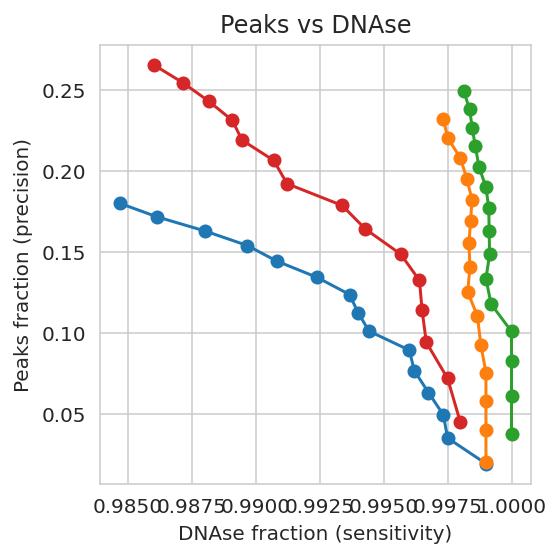

In [64]:
plt.figure(figsize=(4, 4))
for t in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    tt = benchmark_top_df[(benchmark_top_df['cell'] == 'Huvec') &
                          (benchmark_top_df['replicate'] == 'rep1') &
                          (benchmark_top_df['tool'] == t)]
    plt.plot(tt['precision'], tt['sensitivity'], marker='o', label=t)
plt.title('Peaks vs DNAse')
plt.xlabel('DNAse fraction (sensitivity)')
plt.ylabel('Peaks fraction (precision)')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_dnase.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Average precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

In [43]:
cells = []
reps = []
tools = []
aps = []
for c, r, t in tqdm(product(GSE26320_CELLS, GSE26320_REPS, set(df_fdr_peaks['tool']))):
    dft = benchmark_top_df[(benchmark_top_df['cell'] == c) &
                           (benchmark_top_df['replicate'] == r) &
                           (benchmark_top_df['tool'] == t)].copy()
    if len(dft) == 0:
        continue
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - rprev)*row['precision']
        rprev = row['sensitivity']
    cells.append(c)
    reps.append(r)
    tools.append(t)
    aps.append(ap)
aps_df = pd.DataFrame(dict(cell=cells, replicate=reps, tool=tools, ap=aps))

0it [00:00, ?it/s]

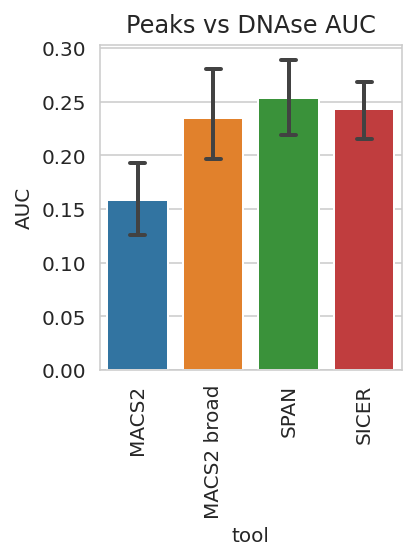

In [44]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs DNAse AUC')
g_results = sns.barplot(data=aps_df, x='tool', y='ap',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_auc.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Functional annotation

In [45]:
tf = tempfile.mktemp()

! rm -r {GSE26320_PATH_HG38}/summary_H3K27ac
! mkdir -p {GSE26320_PATH_HG38}/summary_H3K27ac

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        filename = tool.replace(' ', '_')
        ! cat {peaks_file} >> "{GSE26320_PATH_HG38}/summary_H3K27ac/{filename}.bed_"
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            filename = name.replace(' ', '_')
            ! cat {tf} >> "{GSE26320_PATH_HG38}/summary_H3K27ac/{filename}.bed_"

for f in os.listdir(GSE26320_PATH_HG38 + '/summary_H3K27ac'):
    f_sorted = f[:len(f) - 1]
    ! sort -k1,1 -k2,2n -k3,3n "{GSE26320_PATH_HG38}/summary_H3K27ac/{f}" | cut -f1-3> "{GSE26320_PATH_HG38}/summary_H3K27ac/{f_sorted}"
    ! rm "{GSE26320_PATH_HG38}/summary_H3K27ac/{f}"

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


# Coverage

In [160]:
# Fraction of reads in peaks
GSE26320_PATH_HG38_BW = GSE26320_PATH_HG38 + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if cell and rep and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, rep)
    return df_bws

In [161]:
bws_df = load_bws(GSE26320_PATH_HG38_BW, 'H3K27ac')
display(bws_df.sample(3))
bws_control_df = load_bws(GSE26320_PATH_HG38_BW, 'Input')
display(bws_control_df.sample(3))

  0%|          | 0/103 [00:00<?, ?it/s]

file modification  cell  \
12  /home/jetbrains/data/2023_GSE26320/bw/GSM64637...      H3K27ac  HMEC   
1   /home/jetbrains/data/2023_GSE26320/bw/GSM64647...      H3K27ac  NHLF   
0   /home/jetbrains/data/2023_GSE26320/bw/GSM64643...      H3K27ac  K562   

   replicate  
12      rep1  
1       rep2  
0       rep2

  0%|          | 0/103 [00:00<?, ?it/s]

file modification   cell  \
10  /home/jetbrains/data/2023_GSE26320/bw/GSM64637...        Input  HepG2   
16  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...        Input     H1   
15  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...        Input     H1   

   replicate  
10      rep2  
16      rep2  
15      rep1

In [162]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [163]:
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'replicate', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    # for c, r in tqdm(product(['GM12878'], ['rep1'])):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K27ac') &
                   (bws_df['cell'] == c) & (bws_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]))
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(
                bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        frip_df.loc[len(frip_df)] = (c, r, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

0it [00:00, ?it/s]

GM12878 rep1
MACS2 /tmp/tmp3dcg4nf0 /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SPAN /tmp/tmp_jfad8w0 /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
MACS2 broad /tmp/tmpu8wcc1zq /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SICER /tmp/tmp6ku1fei9 /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
GM12878 rep2
MACS2 /tmp/tmpsxcq1878 /home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646333_GM12878_Input_rep2.bw
SPAN /tmp/tmpil418h6s /home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646333_GM

cell replicate                                            bw_file  \
0   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64631...   
1   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64631...   
2   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64631...   
3   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64631...   
4   GM12878      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64631...   
..      ...       ...                                                ...   
63    HepG2      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...   
64    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...   
65    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...   
66    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...   
67    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64635...   

           tool        peaks_file  peaks     length  reads_in_peaks  \
0         MACS2  /tmp/tmp3dcg4nf0  47290   41890163    4.433343e+07   
1          SPAN  /tmp/tmp_jfad8w0  34842   78383419    5.390837e+07   
2   MACS2 broad  /tmp/tmpu8wcc1zq  31476   65449208    5.098589e+07   
3         SICER  /tmp/tmp6ku1fei9  32861  124120539    5.946370e+07   
4         MACS2  /tmp/tmpsxcq1878  43917   38095017    4.427447e+07   
..          ...               ...    ...        ...             ...   
63        SICER  /tmp/tmppgjwsqpn  28360  112165840    4.810550e+07   
64        MACS2  /tmp/tmpwnhnee5w  26021   16705467    3.410487e+07   
65         SPAN  /tmp/tmpr8lyuo6r  25775   54335027    5.000876e+07   
66  MACS2 broad  /tmp/tmp70flgxrp  16682   25357410    3.957524e+07   
67        SICER  /tmp/tmp8gdg9c2n  27516   89880684    5.501517e+07   

       all_reads  control_reads_in_peaks  control_all_reads  
0   9.604419e+07            1.909556e+06       9.856627e+07  
1   9.605122e+07            4.144245e+06       9.856627e+07  
2   9.604419e+07            3.126710e+06       9.856627e+07  
3   9.599063e+07            6.261552e+06       9.856627e+07  
4   9.692038e+07            1.918134e+06       9.837757e+07  
..           ...                     ...                ...  
63  7.922325e+07            5.364017e+06       8.086781e+07  
64  8.129076e+07            1.934742e+05       8.412824e+07  
65  8.130451e+07            1.720895e+06       8.412824e+07  
66  8.129076e+07            4.861715e+05       8.412824e+07  
67  8.126260e+07            2.806277e+06       8.412824e+07  

[68 rows x 11 columns]

In [164]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / ((z + 1e-10) / 1e3)) / ((y + 1e-10) / 1e6) for x, y, z in
                         zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / (z + 1e-10)) / ((y - x) / (sum(CHROM_SIZES.values()) - z + 1e-10)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / ((y + 1e-10) / 1e6), z / ((u + 1e-10) / 1e6) + 1e-10))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

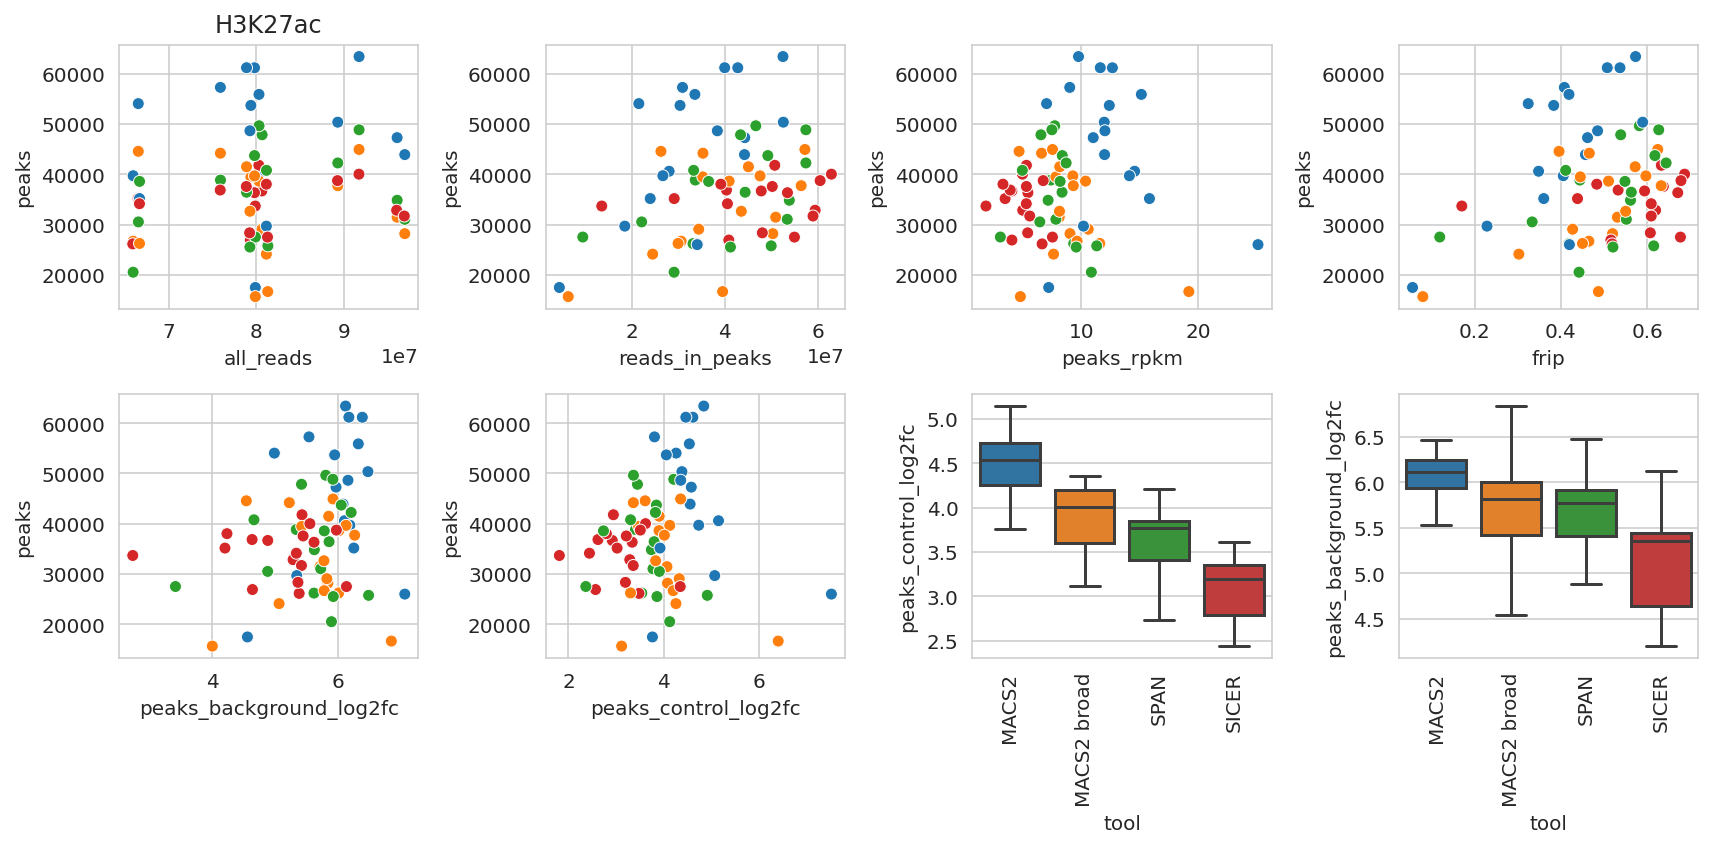

In [165]:
import seaborn as sns

t = frip_df

plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K27ac')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
g_results = sns.boxplot(data=t, x='tool', y='peaks_control_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='peaks_background_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_reads.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [166]:
frip_df.to_csv(f'{GSE26320_PATH_HG38}/pics/H3K27ac_frip.csv.gz', index=None, compression='gzip')

## Peaks Density

In [16]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

coverage_data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    t = bws_df[(bws_df['modification'] == 'H3K27ac') &
               (bws_df['cell'] == c) &
               (bws_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27ac', c, r, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27ac', c, r, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27ac', c, r, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27ac', c, r, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'replicate', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


modification   cell replicate          name                  position  \
5367771      H3K27ac  Huvec      rep2  SPAN - MACS2   chr15:42548031-42549366   
1036674      H3K27ac   HMEC      rep1  SPAN - SICER    chr6:18845714-18845997   
4925377      H3K27ac  Huvec      rep1         SICER   chr19:52569600-52570999   
4258181      H3K27ac   NHLF      rep2          SPAN  chr8:134720010-134721736   
5330483      H3K27ac  Huvec      rep2   MACS2 broad    chr6:63904523-63904945   

         length       type     coverage  total_coverage  
5367771    1335  treatment   694.074941    6.665616e+07  
1036674     283  treatment   106.025689    8.061657e+07  
4925377    1399  treatment  1070.216131    8.924827e+07  
4258181    1726    control    18.359250    8.173756e+07  
5330483     422  treatment   230.752243    6.665616e+07

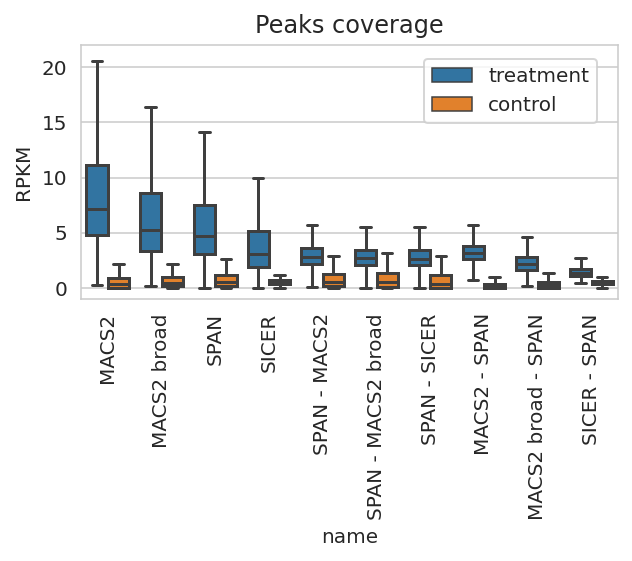

In [17]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad',  'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ],
                        showfliers=False)
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-1, 22)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ChromHMM

In [54]:
CHROMHMM_MAP = {
    'GM12878': GSE26320_PATH_HG38 + '/chromhmm/GM12878_chromhmm_hg38_ENCFF338RIC.bed',
    'H1': GSE26320_PATH_HG38 + '/chromhmm/H1_chromhmm_hg38_ENCFF323HNB.bed',
    'HepG2': GSE26320_PATH_HG38 + '/chromhmm/HepG2_chromhmm_hg38_ENCFF808IZE.bed',
    'K562': GSE26320_PATH_HG38 + '/chromhmm/K562_chromhmm_hg38_ENCFF649FCE.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}
CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
GM12878
H1
HepG2
K562
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [55]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, r, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, r, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'replicate', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell replicate                name  peaks  EnhA1  EnhA2  EnhBiv  EnhG1  \
0   GM12878      rep1                SPAN  34842  15362   9080      18   3540   
1   GM12878      rep1               SICER  32861  14448   8813      38   4704   
2   GM12878      rep1         MACS2 broad  31476  15301   8829       6   2654   
3   GM12878      rep1               MACS2  47290  21700  10685       3   1560   
4   GM12878      rep1        SPAN - MACS2   9741   1725    801      12   1107   
..      ...       ...                 ...    ...    ...    ...     ...    ...   
65    HepG2      rep2        MACS2 - SPAN      0      0      0       0      0   
66    HepG2      rep2  SPAN - MACS2 broad  10347   4830    597      22   1427   
67    HepG2      rep2  MACS2 broad - SPAN      0      0      0       0      0   
68    HepG2      rep2        SPAN - SICER    341     98      5       2     30   
69    HepG2      rep2        SICER - SPAN   3942    682     95      23   1006   

    EnhG2  EnhWk  ...  ReprPC  ReprPCWk   TssA  TssBiv  TssFlnk  TssFlnkD  \
0    1728  19850  ...     159       157  11145      32    14975      5968   
1    1639  22690  ...     864       857  10788      64    14851      7766   
2    1723  15742  ...     104       103  11174      21    14184      4445   
3    2076  10878  ...      41        41  17978      11    17825      2466   
4     105   6206  ...      61        59    351      15     1952      1218   
..    ...    ...  ...     ...       ...    ...     ...      ...       ...   
65      0      0  ...       0         0      0       0        0         0   
66    618   4573  ...       8         8   1740      65     3335      1402   
67      0      0  ...       0         0      0       0        0         0   
68      9    139  ...       0         0      9       0       56        34   
69     44   2536  ...      36        33    127      30      768       616   

    TssFlnkU     Tx   TxWk  ZNF_Rpts  
0       7461   9039   8351         0  
1       7163  20422  19265         0  
2       7478   5868   5489         0  
3       9248   2420   2309         0  
4        232   2662   2335         0  
..       ...    ...    ...       ...  
65         0      0      0         0  
66      1713    928    660         0  
67         0      0      0         0  
68        17     38     25         0  
69       131   2118   1536         0  

[70 rows x 22 columns]

In [56]:
chromhmm_df_mean = chromhmm_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_df_mean = chromhmm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                         ]]
chromhmm_df_mean

EnhA1        EnhA2      EnhBiv        EnhG1  \
name                                                                     
MACS2               14635.142857  5034.571429  151.857143  1052.142857   
MACS2 broad         10893.714286  4613.285714  211.285714  1896.714286   
SPAN                11805.428571  5209.285714  184.571429  2311.714286   
SICER               12213.142857  5829.142857  463.000000  4066.142857   
SPAN - MACS2         2420.142857   874.285714   47.428571   729.000000   
SPAN - MACS2 broad   1489.285714   504.714286   32.000000   476.571429   
SPAN - SICER           76.000000    33.000000   14.142857    33.714286   
MACS2 - SPAN          174.142857    28.714286    9.857143    78.571429   
MACS2 broad - SPAN    474.285714    92.285714   46.571429   298.714286   
SICER - SPAN          788.857143   315.285714   91.000000   610.000000   

                          EnhG2         EnhWk         Het        Quies  \
name                                                                     
MACS2               1694.714286   6668.571429   91.428571  2207.000000   
MACS2 broad         1452.142857   9900.571429  169.571429  3234.428571   
SPAN                1605.142857  11546.857143  165.571429  2342.142857   
SICER               1662.428571  18703.142857  584.000000  7276.142857   
SPAN - MACS2         204.571429   3611.428571   38.714286   509.714286   
SPAN - MACS2 broad   125.571429   2316.714286   21.285714   298.142857   
SPAN - SICER           7.571429    230.285714    3.285714    64.857143   
MACS2 - SPAN          15.000000    361.428571    8.285714   271.142857   
MACS2 broad - SPAN    46.000000   1307.857143   40.000000  1023.428571   
SICER - SPAN          55.000000   2839.857143   85.857143  1428.285714   

                         ReprPC    ReprPCWk          TssA      TssBiv  \
name                                                                    
MACS2                133.285714   85.714286  15207.714286  542.857143   
MACS2 broad          327.142857  228.857143  10044.571429  481.714286   
SPAN                 164.428571  122.000000  10315.142857  465.142857   
SICER               1010.857143  837.714286  10325.285714  742.142857   
SPAN - MACS2          41.285714   34.714286    843.142857  102.285714   
SPAN - MACS2 broad    26.428571   23.000000    500.142857   71.000000   
SPAN - SICER           6.428571    4.428571     27.714286   12.714286   
MACS2 - SPAN          25.428571   16.714286     76.857143   34.142857   
MACS2 broad - SPAN   168.571429  114.714286    140.571429   94.000000   
SICER - SPAN         204.428571  168.142857    168.571429  112.142857   

                         TssFlnk     TssFlnkD      TssFlnkU            Tx  \
name                                                                        
MACS2               15445.714286  2004.428571  10742.000000   2364.571429   
MACS2 broad         11936.285714  3378.285714   8346.714286   4733.857143   
SPAN                12964.714286  4202.000000   8783.142857   4925.428571   
SICER               13859.285714  7136.571429   8883.285714  15651.428571   
SPAN - MACS2         1766.714286   764.571429    693.142857   1569.857143   
SPAN - MACS2 broad   1103.285714   482.000000    414.000000   1024.000000   
SPAN - SICER           97.285714    38.285714     20.571429    111.714286   
MACS2 - SPAN          256.571429    76.285714    109.285714    202.571429   
MACS2 broad - SPAN    512.142857   202.428571    223.142857   1075.000000   
SICER - SPAN          700.428571   425.285714    231.571429   2912.857143   

                            TxWk  ZNF_Rpts  
name                                        
MACS2                2154.285714       0.0  
MACS2 broad          4128.285714       0.0  
SPAN                 4413.714286       0.0  
SICER               14348.714286       0.0  
SPAN - MACS2         1331.857143       0.0  
SPAN - MACS2 broad    851.000000       0.0  
SPAN - SICER           89.428571       0.0  
MACS2 - SPAN          149.857143       0.0

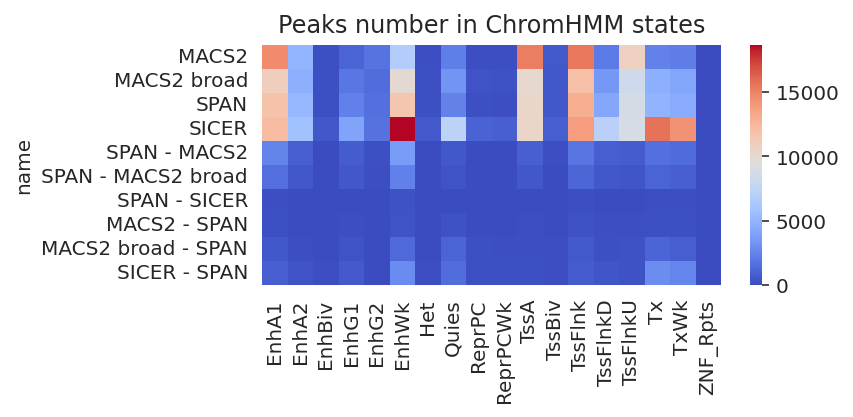

In [57]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_df_mean, cmap='coolwarm')
plt.title('Peaks number in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [58]:
chromhmm_rel_df = chromhmm_df[['name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chromhmm_df[state], chromhmm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_rel_df_mean = chromhmm_rel_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                                 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                                 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                                 ]]
chromhmm_rel_df_mean

EnhA1     EnhA2    EnhBiv     EnhG1     EnhG2  \
name                                                                   
MACS2               0.361161  0.123255  0.003312  0.023013  0.040765   
MACS2 broad         0.403383  0.170646  0.006515  0.061978  0.053038   
SPAN                0.428511  0.182626  0.007551  0.081928  0.059226   
SICER               0.413076  0.191837  0.016488  0.138196  0.057304   
SPAN - MACS2        0.310990  0.082661  0.012873  0.105159  0.035071   
SPAN - MACS2 broad  0.249469  0.062038  0.029979  0.119918  0.046527   
SPAN - SICER        0.133469  0.032845  0.030117  0.074543  0.036179   
MACS2 - SPAN        0.206333  0.021826  0.003320  0.060907  0.007080   
MACS2 broad - SPAN  0.083226  0.042134  0.004421  0.062026  0.006492   
SICER - SPAN        0.138298  0.052035  0.015487  0.136523  0.010019   

                       EnhWk       Het     Quies    ReprPC  ReprPCWk  \
name                                                                   
MACS2               0.145620  0.001992  0.048340  0.002864  0.001830   
MACS2 broad         0.324912  0.005398  0.101486  0.009497  0.006684   
SPAN                0.409375  0.005630  0.090216  0.006386  0.004575   
SICER               0.631020  0.019054  0.248311  0.034752  0.028531   
SPAN - MACS2        0.479781  0.005371  0.094999  0.007447  0.005185   
SPAN - MACS2 broad  0.459689  0.004436  0.078707  0.008371  0.005029   
SPAN - SICER        0.337514  0.003695  0.086807  0.006987  0.003745   
MACS2 - SPAN        0.263312  0.007671  0.133825  0.012278  0.009536   
MACS2 broad - SPAN  0.349223  0.008787  0.161403  0.016907  0.012156   
SICER - SPAN        0.570991  0.020870  0.246119  0.037459  0.031200   

                        TssA    TssBiv   TssFlnk  TssFlnkD  TssFlnkU  \
name                                                                   
MACS2               0.418156  0.012083  0.383334  0.044728  0.269004   
MACS2 broad         0.400732  0.015806  0.449285  0.112965  0.314798   
SPAN                0.381812  0.019057  0.478263  0.151938  0.334093   
SICER               0.350487  0.026007  0.470366  0.242658  0.308137   
SPAN - MACS2        0.076120  0.013609  0.195831  0.087551  0.082011   
SPAN - MACS2 broad  0.053161  0.015606  0.164437  0.082010  0.057398   
SPAN - SICER        0.023753  0.018483  0.139966  0.060784  0.038446   
MACS2 - SPAN        0.029133  0.012561  0.113307  0.039803  0.040719   
MACS2 broad - SPAN  0.030662  0.010818  0.134581  0.054389  0.030207   
SICER - SPAN        0.029041  0.018476  0.146315  0.094326  0.039085   

                          Tx      TxWk  ZNF_Rpts  
name                                              
MACS2               0.052070  0.047658       0.0  
MACS2 broad         0.151832  0.133594       0.0  
SPAN                0.175365  0.157096       0.0  
SICER               0.523638  0.479316       0.0  
SPAN - MACS2        0.200217  0.168027       0.0  
SPAN - MACS2 broad  0.202482  0.162364       0.0  
SPAN - SICER        0.143227  0.103194       0.0  
MACS2 - SPAN        0.258961  0.238432       0.0  
MACS2 broad - SPAN  0.258784  0.207613       0.0  
SICER - SPAN        0.582877  0.500602       0.0

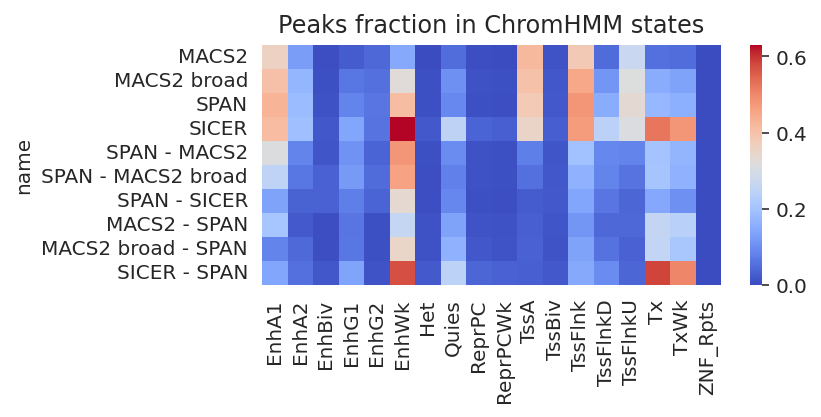

In [59]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_rel_df_mean, cmap='coolwarm')
plt.title('Peaks fraction in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_chromhmm_rel.pdf', bbox_inches='tight', dpi=300)
plt.show()